<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/Seq_JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title data
import torch
import torchvision
import torchvision.transforms as transforms
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform = transforms.Compose([transforms.ToTensor(),])

# train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transform) # do not normalise! want img in [0,1)
# test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform) #opt no download
# # batch_size = 32 # 64 512
# batch_size = 32 if torch.cuda.is_available() else 32

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
batch_size = 128 # 128 1024
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# dataiter = iter(train_data)
# x,y = next(dataiter)
# print(x.shape) # [3, 32, 32]

100%|██████████| 170M/170M [00:02<00:00, 62.9MB/s]


In [ ]:
# @title rohanpandey WISDM
# https://github.com/rohanpandey/Analysis--WISDM-Smartphone-and-Smartwatch-Activity/blob/master/dataset_creation.ipynb
! wget https://archive.ics.uci.edu/static/public/507/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip
!unzip wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset.zip
!unzip wisdm-dataset.zip

import glob
import pandas as pd
import os

folder1=glob.glob("wisdm-dataset/raw/*")
# print(folder1)
column_names = ['ID', 'activity','timestamp','x','y','z']
overall_dataframe=pd.DataFrame(columns = column_names)
for subfolder in folder1:
    parent_dir = "./processed/"
    path = os.path.join(parent_dir, subfolder.split('\\')[-1])
    if not os.path.exists(path): os.makedirs(path)
    folder2=glob.glob(subfolder+"/*")
    for subsubfolder in folder2:
        activity_dataframe = pd.DataFrame(columns = column_names)
        subfolder_path = os.path.join(path, subsubfolder.split('/')[-1])
        if not os.path.exists(subfolder_path): os.makedirs(subfolder_path)
        files=glob.glob(subsubfolder+"/*")
        for file in files:
            # print(file)
            df = pd.read_csv(file, sep=",",header=None)
            df.columns = ['ID','activity','timestamp','x','y','z']
            # activity_dataframe=activity_dataframe.append(df)
            activity_dataframe = pd.concat([activity_dataframe, df], ignore_index=True)

        activity_dataframe['z']=activity_dataframe['z'].str[:-1]
        # activity_dataframe['meter']=subsubfolder.split('/')[-1]
        # activity_dataframe['device']=subfolder.split('/')[-1]
        activity_dataframe.to_csv(subfolder_path+'/data.csv',index=False)


In [2]:
# @title buffer dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset

# /content/processed/wisdm-dataset/raw/phone/accel/data.csv
# /content/processed/wisdm-dataset/raw/watch/gyro/data.csv

class BufferDataset(Dataset):
    def __init__(self):
        # df_keep = pd.read_csv("data.csv")#[['ID','activity','timestamp','x','y','z']]
        df_keep = pd.read_csv("/content/processed/wisdm-dataset/raw/watch/accel/data.csv")

        user_acts = dict(tuple(df_keep.groupby(['ID','activity'])[['timestamp','x','y','z']]))
        self.data = [[d.to_numpy(), a] for a, d in user_acts.items()]
        self.act_dict = {i: act for i, act in enumerate(df_keep['activity'].unique())}
        self.act_invdict = {v: k for k, v in self.act_dict.items()} # {'A': 0, 'B': 1, ...

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x, id_act = self.data[idx]
        id_act = self.process(id_act)
        return torch.tensor(x[:3500]), id_act # 3567

    def process(self, id_act):
        return int(id_act[0]), self.act_invdict[id_act[1]]

    def transform(self, act_list): # rand resize crop, rand mask # https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html
        act_list = np.array(act_list)
        try: hr, temp, heart= zip(*act_list)
        except ValueError: print('err:',act_list)
        kind = 'nearest' if len(act_list)>self.seq_len/.7 else 'linear'
        temp_interpolator = scipy.interpolate.interp1d(hr, temp, kind=kind) # linear nearest quadratic cubic
        heart_interpolator = scipy.interpolate.interp1d(hr, heart, kind=kind) # linear nearest quadratic cubic
        hr_ = np.sort(np.random.uniform(hr[0], hr[-1], round(self.seq_len*random.uniform(1,1/.7))))
        temp_, heart_ = temp_interpolator(hr_), heart_interpolator(hr_)
        act_list = list(zip(hr_, temp_, heart_))

        idx = torch.randint(len(act_list)-self.seq_len+1, size=(1,))
        # return act_list[idx: idx+self.seq_len]
        act_list = act_list[idx: idx+self.seq_len]

        # mask=(torch.rand(self.seq_len)<.1) # True -> masked # random masking
        # # act_list[mask] = self.pad[0]
        # act_list = [self.pad[0] if m else a for m,a in zip(mask, act_list)]
        return act_list

    def add(self, episode):
        self.data.append(episode)

import numpy as np
from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(3, 3))
    # print(npimg.shape) # (3, 64, 64)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# df_keep = pd.read_csv("data.csv")#[['ID','activity','timestamp','x','y','z']]
# user_acts = dict(tuple(df_keep.groupby(['ID','activity'])[['timestamp','x','y','z']]))
# dataset = [[d.to_numpy(), a] for a, d in user_acts.items()]


train_data = BufferDataset() # one line of poem is roughly 50 characters

dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(0.7 * dataset_size))
np.random.seed(0)
np.random.shuffle(indices)
train_indices, val_indices = indices[:split], indices[split:]

from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

from torch.utils.data.dataloader import DataLoader
batch_size = 64 #512
train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)


In [3]:
# @title (Learned)RotEmb
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class RoPE(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, seq_len=512, base=10000):
        super().__init__()
        self.dim, self.base = dim, base
        theta = 1.0 / (base ** (torch.arange(0, dim, step=2) / dim))
        pos = torch.arange(seq_len).unsqueeze(-1)
        angles = (pos * theta)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
        self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [seq_len, dim // 2, 2] -> [1, seq_len, dim]

    def forward(self, x):
        seq_len = x.size(1)
        if self.rot_emb.shape[0] < seq_len: self.__init__(self.dim, seq_len, self.base)
        return x * self.rot_emb[:seq_len]

# class LearnedRoPE(nn.Module): # learnt RoPE ; each tok is 1 pos
#     def __init__(self, dim):
#         super().__init__()
#         self.weights = nn.Parameter(torch.randn(1, dim//2))

#     def forward(self, x): #
#         batch, seq_len, dim = x.shape
#         # if rot_emb.shape[0] < seq_len: self.__init__(dim, seq_len)
#         pos = torch.arange(seq_len).unsqueeze(1)
#         angles = (self.weights * pos * 2*torch.pi).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
#         rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
#         return x * rot_emb.flatten(-2).unsqueeze(0)


class LearnedRoPE(nn.Module): # learnt RoPE ; each tok is 1 pos
    def __init__(self, dim, seq_len=512):
        super().__init__()
        self.dim = dim
        self.weights = nn.Parameter(torch.randn(1, dim//2))
        pos = torch.arange(seq_len).unsqueeze(1)
        angles = (self.weights * pos * 2*torch.pi)[None,...,None] # [seq_len, 1] * [dim // 2] -> [1, seq_len, dim // 2, 1]
        self.rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1).flatten(-2).to(device) # [seq_len, dim // 2, 2] -> [1, seq_len, dim]

    def forward(self, x): # [batch, seq_len, dim]
        seq_len = x.size(1)
        if self.rot_emb.shape[0] < seq_len: self.__init__(self.dim, seq_len)
        return x * self.rot_emb[:seq_len]


class RotEmb(nn.Module): # Rotary Positional Embeddings
    def __init__(self, dim, top=torch.pi, base=10000):
        super().__init__()
        self.theta = top / (base ** (torch.arange(0, dim, step=2, device=device) / dim))
        # self.theta = top / (base ** torch.linspace(0, 1, dim//2, device=device))

    def forward(self, pos): # [batch] in [0,1]
        angles = (pos.unsqueeze(-1) * self.theta).unsqueeze(-1) # [seq_len, 1] * [dim // 2] -> [seq_len, dim // 2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [seq_len, dim // 2, 2]
        return rot_emb.flatten(-2) # [seq_len, dim]

class LearnedRotEmb(nn.Module): # pos in R
    def __init__(self, dim):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((1, dim//2), device=device))

    def forward(self, pos): # [batch] in [0,1]
        angles = (self.weights * pos.unsqueeze(-1) * 2*torch.pi).unsqueeze(-1) # [batch, 1] * [1, dim//2] -> [batch, dim//2, 1]
        rot_emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1) # [batch, dim // 2, 2]
        return rot_emb.flatten(-2) # [batch, dim]



In [4]:
# @title ViT me simple wisdm
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    """Zero out the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().zero_()
    return module

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads=None, d_head=8, cond_dim=None, dropout=0.): # .1
        super().__init__()
        self.d_model = d_model
        self.d_head = d_head
        self.n_heads = d_model // d_head
        # self.d_head = d_model // n_heads
        self.cond_dim = cond_dim
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.kv = nn.Linear(cond_dim or d_model, 2*d_model, bias=False)
        # self.k = nn.Sequential(nn.Dropout(dropout), nn.Linear(cond_dim, d_model, bias=False))
        # self.lin = nn.Linear(d_model, d_model)
        self.lin = zero_module(nn.Linear(d_model, d_model))
        # self.lin = nn.Sequential(nn.Dropout(dropout), zero_module(nn.Linear(d_model, d_model)))
        self.drop = nn.Dropout(dropout) # indp before q,k,v; after linout
        self.scale = self.d_head ** -.5

    def forward(self, x, cond=None, mask=None): # [batch, T, d_model]=[batch, h*w, c], [batch, num_tok, cond_dim], [batch,T]
        batch = x.shape[0]
        if self.cond_dim==None: cond=x # is self attn
        Q = self.q(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2) # [batch, T, d_model] -> [batch, n_heads, T, d_head]
        # K = self.k(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2)
        K, V = self.kv(cond).view(batch, -1, self.n_heads, 2*self.d_head).transpose(1, 2).chunk(2, dim=-1) # [batch, n_heads, T/num_tok, d_head]

        # # linear attention # Softmax(Q) @ (Softmax(K).T @ V)
        if mask != None:
            mask = mask[:, None, :, None] # [batch,T] -> [batch,1,T,1]
            K, V = K.masked_fill(mask, -torch.finfo(x.dtype).max), V.masked_fill(mask, -torch.finfo(x.dtype).max)
        Q, K = Q.softmax(dim=-1)*self.scale, K.softmax(dim=-2)
        context = K.transpose(-2,-1) @ V # [batch, n_heads, d_head, d_head]
        out = Q @ context # [batch, n_heads, T/num_tok, d_head]

        # # (quadratic) attention # Softmax(Q @ K.T) @ V
        # attn = Q @ K.transpose(-2,-1) * self.scale # [batch, n_heads, T] # [batch, n_heads, T, T/num_tok]
        # if mask != None: attn = attn.masked_fill(mask[:, None, :, None], -torch.finfo(attn.dtype).max) # [batch,T]->[batch,1,T,1]
        # attention = torch.softmax(attn, dim=-1)
        # out = self.drop(attention) @ V # [batch, n_heads, T, d_head]

        out = out.transpose(1, 2).flatten(2)
        return self.drop(self.lin(out)) # [batch, T, d_model]

# if self, dont pass cond_dim in init, dont pass cond in fwd
# Softmax(Q @ K.T) @ V ~ Softmax(Q) @ Softmax(K).T @ V

# https://github.com/lucidrains/x-transformers/blob/main/x_transformers/x_transformers.py#L1855

class AttentionBlock(nn.Module):
    def __init__(self, d_model, d_head=4, cond_dim=None, ff_mult=1, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.norm2 = nn.RMSNorm(d_model)
        self.drop = nn.Dropout(dropout)
        self.cond_dim = cond_dim
        self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0)
        if self.cond_dim!=None: self.cross = MultiHeadAttention(d_model, d_head=d_head, cond_dim=cond_dim, dropout=0)
        act = nn.GELU() # ReLU GELU
        ff_dim=d_model*ff_mult
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(d_model, ff_dim), act, # ReLU GELU
            # nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
            nn.RMSNorm(d_model), nn.Dropout(dropout), zero_module(nn.Linear(ff_dim, d_model))
            # nn.RMSNorm(d_model), act, nn.Dropout(dropout), nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
        )

    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        # bchw = x.shape
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]

        if self.cond_dim==None: cond=None # is self attn
        x = x + self.drop(self.self(self.norm1(x), cond, mask))
        if self.cond_dim!=None: x = x + self.cross(self.norm2(x), cond, mask)
        x = x + self.ff(x)
        # x = x + self.drop(self.ff(x))

        # return x.transpose(1,2).reshape(*bchw)
        return x

import torch
# https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
def apply_masks(x, masks):
    """:param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep"""
    all_x = []
    for m in masks: # [1,T]
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1)) # [1,T,dim]
        all_x += [torch.gather(x, dim=1, index=mask_keep)] # M * [batch,mask_size,dim]
    return torch.cat(all_x, dim=0)  # [M*batch,mask_size,dim]


class TransformerPredictor(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
    def __init__(self, in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1, dropout = 0.):
        super().__init__()
        self.embed = nn.Linear(in_dim, d_model)# if in_dim != d_model else None
        self.pos_encoder = RotEmb(d_model, top=1, base=10000)
        # self.positional_emb = nn.Parameter(torch.zeros(1, 32*32//4, d_model)) # positional_embedding == 'learnable'
        # encoder_layers = nn.TransformerEncoderLayer(d_model, d_model//d_head, d_hid or d_model, dropout, batch_first=True)
        # self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.transformer_encoder = nn.Sequential(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])

        self.cls = nn.Parameter(torch.zeros(1,1,d_model)) # randn zeros
        nn.init.trunc_normal_(self.cls, std=.02)
        out_dim = out_dim or d_model
        self.norm = nn.RMSNorm(d_model)
        self.lin = nn.Linear(d_model, out_dim)# if out_dim != d_model else None

    def forward(self, src, context_indices, trg_indices): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        src = self.embed(src) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = src.shape
        src = src * self.pos_encoder(context_indices)
        # src = src + self.positional_emb[:,context_indices]
        # src = apply_masks(src, [context_indices])

        pred_tokens = self.cls * self.pos_encoder(trg_indices) # [M, num_trg_toks, d_model]
        # pred_tokens = self.cls + self.positional_emb[0,trg_indices]
        pred_tokens = pred_tokens.repeat(batch, 1, 1) # [batch*M, num_trg_toks, d_model]
        # print(pred_tokens.requires_grad)
        # print("pred fwd", src.shape, pred_tokens.shape)
        # src = src.repeat_interleave(trg_indices.shape[0], dim=0) # [batch, seq_len, d_model] -> [batch*M, seq_len, d_model]
        src = torch.cat([src, pred_tokens], dim=1) # [batch*M, seq_len+num_trg_toks, d_model]

        out = self.transformer_encoder(src) # float [seq_len, batch_size, d_model]
        out = self.norm(out)
        out = out[:,seq:] # [batch*M, num_trg_toks, d_model]
        out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]


class TransformerModel(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
    def __init__(self, in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1, dropout = 0.):
        super().__init__()

        # self.calorie_emb = RotEmb(dim, top=1, base=10) # 0-4
        # self.steps_emb = RotEmb(dim, top=1, base=10) # 0-5
        # self.enc0 = nn.Sequential(
        #     nn.Linear(dim*2, d_model), act,
        #     nn.Linear(d_model, d_model), act,
        # )
        # self.hour_emb = CircularEmb(dim, torch.pi/2) # circular (0,1) # 0-24
        # self.temp_emb = RotEmb(dim, top=1/3, base=10) # 18-35
        # self.heart_emb = RotEmb(dim, top=1/3, base=100) # 50-200
        # self.enc1 = nn.Sequential(
        #     nn.Linear(dim*3, d_model), act,
        # )

        self.embed = nn.Sequential(
            # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.MaxPool1d(2,2), #nn.MaxPool1d(3, 2, 3//2),
            # nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.Conv1d(d_model, d_model,3,2,3//2)
            nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2),
            # nn.Conv1d(in_dim, d_model,2,2,0), # like patch
            )
        self.pos_encoder = RotEmb(d_model, top=1, base=10000)
        # self.positional_emb = nn.Parameter(torch.zeros(1, 32*32//4, d_model)) # positional_embedding == 'learnable'
        # encoder_layers = nn.TransformerEncoderLayer(d_model, d_model//d_head, d_hid or d_model, dropout, batch_first=True)
        # self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.transformer_encoder = nn.Sequential(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])
        self.norm = nn.RMSNorm(d_model)
        self.lin = nn.Linear(d_model, out_dim) if out_dim and out_dim != d_model else None

    def forward(self, src, context_indices=None): # [batch, num_context_toks, 3], [batch, num_context_toks] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html

        # src = self.embed(src) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        src = self.embed(src.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]

        batch, seq, dim = src.shape

        # # # src = self.pos_encoder(src)
        # if context_indices != None:
        # print(src.shape, self.pos_encoder(context_indices).shape)
        #     src = src * self.pos_encoder(context_indices) # context/predictor # src = src + self.positional_emb[:,context_indices]
        # else: src = src * self.pos_encoder(torch.arange(seq, device=device).unsqueeze(0)) # target # src = src + self.positional_emb[:,:seq]


        # src = self.pos_encoder(src)
        src = src * self.pos_encoder(torch.arange(seq, device=device)).unsqueeze(0)
        # src = src + self.positional_emb
        if context_indices != None:
            src = apply_masks(src, [context_indices])


        out = self.transformer_encoder(src) # float [seq_len, batch_size, d_model]
        out = self.norm(out)
        if self.lin: out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]


batch, seq_len, d_model = 4,1024,16
in_dim = 3
model = TransformerModel(in_dim, d_model, d_head=4, nlayers=2, dropout=0.).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 27584
x =  torch.rand((batch, seq_len, in_dim), device=device)
out = model(x)
print(out.shape)
# # print(out)


5104
torch.Size([4, 32, 16])


In [ ]:
# @title RNN pytorch
device = "cuda" if torch.cuda.is_available() else "cpu"

class RNN(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, num_layers=1):
        super().__init__()
        if out_dim is None: out_dim = in_dim
        self.num_layers = num_layers
        self.d_model = d_model
        # self.rnn = nn.RNN(d_model, d_model, num_layers, batch_first=True)
        self.rnn = nn.GRU(in_dim, d_model, num_layers, batch_first=True)
        # self.lstm = nn.LSTM(d_model, d_model, num_layers, batch_first=True)
        self.fc = nn.Linear(d_model, out_dim)

        # self.emb = nn.Embedding(in_dim, d_model)
        self.mask_vec = nn.Parameter(torch.randn(in_dim))


    # def forward(self, x, hc=None): # lstm [batch_size, seq, in_dim]
    #     x = self.emb(x)
    #     if hc is None:
    #         h0 = torch.zeros((self.num_layers, x.size(0), self.d_model), device=device)
    #         c0 = torch.zeros((self.num_layers, x.size(0), self.d_model), device=device)
    #     else: h0,c0 = hc
    #     # print(x.shape, h0.shape,c0.shape)
    #     out, (h,c) = self.lstm(x, (h0,c0)) # [batch, seq_len, d_model], ([num_layers, batch, d_model] )
    #     # out = out[:, -1, :] # out: (n, 128)
    #     out = self.fc(out) # out: (n, 10)
    #     return out, (h, c)

    def reset(self, batch):
        h0 = torch.zeros((self.num_layers, batch, self.d_model), device=device)
        return h0

    def forward(self, x, h0=None, mask=None): # rnn/gru # [batch, T, in_dim], [num_layers, batch, d_model], [batch, T] True->masked
        # x = self.emb(x)
        if h0==None: h0 = self.reset(x.shape[0])
        # print(x.shape, h0.shape)
        if mask!=None: x[mask] = self.mask_vec.to(x.dtype)
        out, h = self.rnn(x, h0) #
        out = out[:, -1, :] # out: (n, 128)
        out = self.fc(out) # out: (n, 10)
        return out, h # [batch, out_dim], [num_layers, batch, d_model]


# hidden_size = 128
# num_layers = 2
# input_size = num_classes = 4

# model = RNN(input_size, hidden_size, num_classes, num_layers).to(device)
# # # print(model)
# # print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# batch=2
# seq_len=3
# x=torch.rand(batch,seq_len,input_size).to(device)
# h=torch.rand(num_layers,batch,hidden_size).to(device)
# mask=(torch.rand(batch,seq_len)<.5)#.expand(-1,-1,x.size(-1))
# print(mask)
# print(x)
# out,h = model(x, h, mask)
# print(out.shape)
# print(h.shape)


In [6]:
# @title TransformerVICReg
import math
import os
import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import inspect
class Seq(nn.Sequential):
    def __init__(self, *args):
        super().__init__(*args)
        for layer in self:
            params = inspect.signature(layer.forward).parameters.keys()
            layer._fwdparams = ','.join(params)

    def forward(self, x, mask=None, cond=None):
        for layer in self:
            args = [x]
            if 'mask' in layer._fwdparams: args.append(mask)
            if 'cond' in layer._fwdparams: args.append(cond)
            x = layer(*args)
        return x

class TransformerVICReg(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1, drop=0):
        super().__init__()
        act = nn.GELU()
        # self.embed = nn.Sequential(nn.Linear(in_dim, d_model), act)
        self.embed = nn.Sequential(
            nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.MaxPool1d(2,2),
            nn.Conv1d(d_model, d_model,3,2,3//2),
            )
        self.pos_encoder = RoPE(d_model, seq_len=200, base=10000)
        # d_hid = d_hid or d_model#*2
        # self.encoder = nn.Sequential(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])
        self.encoder = Seq(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])

        out_dim = out_dim or d_model
        self.lin = nn.Linear(d_model, out_dim)
        self.attention_pool = nn.Linear(d_model, 1, bias=False)

        dim_v = d_model * 4
        self.exp = nn.Sequential(
            nn.Linear(out_dim, dim_v), act,
            nn.Linear(dim_v, dim_v), act,
            nn.Linear(dim_v, dim_v, bias=False),
            )

    def forward(self, x, src_key_padding_mask=None): # [batch, seq, d_model], [batch, seq] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # x = self.embed(x)
        x = self.embed(x.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]
        # batch, seq_len, d_model = x.shape
        # x = torch.cat([self.cls.repeat(batch,1,1), x], dim=1)
        # src_key_padding_mask = torch.cat([torch.zeros((batch, 1), dtype=torch.bool), src_key_padding_mask], dim=1)
        x = self.pos_encoder(x)

        x = self.encoder(x, mask=src_key_padding_mask)
        # print("fwd",out.shape) # float [batch, seq_len, d_model]

        attn = self.attention_pool(x).squeeze(-1) # [batch, seq] # seq_pool
        out = (torch.softmax(attn, dim=-1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, seq] @ [batch, seq, dim] -> [batch, dim]
        out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]

    def expand(self, x, src_key_padding_mask=None):
        sx = self.forward(x, src_key_padding_mask=src_key_padding_mask)
        vx = self.exp(sx)
        return vx

batch, seq_len, d_model = 4,3500,512
in_dim, out_dim=3,16
model = TransformerVICReg(in_dim, d_model, out_dim, d_head=4, nlayers=2, drop=0.).to(device)
x =  torch.rand((batch, seq_len, in_dim), device=device)
src_key_padding_mask = torch.stack([(torch.arange(seq_len) < seq_len - v) for v in torch.randint(seq_len, (batch,))]) # True will be ignored # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
print(src_key_padding_mask)
out = model(x, src_key_padding_mask)
print(out.shape)


tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False]])
torch.Size([4, 16])


In [11]:
# @title Violet
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class Violet(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, nlayers=2, d_head=4):
        super().__init__()
        out_dim = out_dim or d_model

        # self.rnn = RNN(d_model, d_model, d_model, nlayers)
        self.student = TransformerVICReg(in_dim, d_model, out_dim=out_dim, d_head=d_head, nlayers=nlayers, drop=0.)
        import copy
        self.teacher = copy.deepcopy(self.student)
        self.teacher.requires_grad_(False)

        # vicreg
        self.sim_coeff=25. # 10.0 # 25.0 # λ
        self.std_coeff=25. # 1.0 # 25.0 # µ
        self.cov_coeff=1. # 25.0 # 1.0 # ν

        self.classifier = nn.Linear(out_dim, 18) # 10 18

    def loss(self, x, src_key_padding_mask=None): # [batch, T, 3]
        batch, seq, dim = x.shape
        # print(x.shape)
        vx = self.student.expand(x, src_key_padding_mask=src_key_padding_mask) # [batch, num_context_toks, out_dim]
        with torch.no_grad(): vy = self.teacher.expand(x.detach(), src_key_padding_mask=src_key_padding_mask) # [batch, num_trg_toks, out_dim]
        loss = self.vicreg(vx, vy)
        return loss

    def forward(self, x, src_key_padding_mask=None): # [batch, T, 3]
        sx = self.student(x, src_key_padding_mask=src_key_padding_mask)
        return sx

    def classify(self, x): # [batch, T, 3]
        sx = self.forward(x)
        out = self.classifier(sx)
        return out


    # https://arxiv.org/pdf/2105.04906.pdf
    def vicreg(self, x, y): # https://github.com/facebookresearch/vicreg/blob/main/main_vicreg.py
        # invariance loss
        repr_loss = F.mse_loss(x, y) # s(Z, Z')

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        # variance loss
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        batch_size, num_features = x.shape

        if x.dim() == 1: x = x.unsqueeze(0)
        if y.dim() == 1: y = y.unsqueeze(0)

        # # covariance loss
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_y = (y.T @ y) / (batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)\
         + off_diagonal(cov_y).pow_(2).sum().div(num_features) #c(Z)
        loss = self.sim_coeff * repr_loss + self.std_coeff * std_loss + self.cov_coeff * cov_loss
        print("in vicreg ",self.sim_coeff * repr_loss.item() , self.std_coeff * std_loss.item() , self.cov_coeff * cov_loss.item())
        # return loss
        return repr_loss, std_loss, cov_loss


violet = Violet(in_dim=3, d_model=32, out_dim=16, nlayers=2, d_head=4).to(device)
# voptim = torch.optim.AdamW(violet.parameters(), lr=1e-3) # 1e-3?
voptim = torch.optim.AdamW([{'params': violet.student.encoder.parameters()},
    {'params': violet.student.exp.parameters(), 'lr': 3e-3}], lr=1e-3, weight_decay=1e-2) # default 1e-2
print(sum(p.numel() for p in violet.parameters() if p.requires_grad)) # 27584

x = torch.rand((2,1000,3), device=device)
# x = torch.rand((2,1,16), device=device)
loss = violet.loss(x)
# print(out.shape)
print(loss)


55330
in vicreg  2.7820201582526456e-16 24.747037887573242 1.4539491832721296e-09
(tensor(1.1128e-17, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(0.9899, device='cuda:0', grad_fn=<AddBackward0>), tensor(1.4539e-09, device='cuda:0', grad_fn=<AddBackward0>))


In [ ]:
# @title SeqJEPA mae like
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"

def symlog(x): return torch.sign(x) * torch.log(torch.abs(x) + 1.0)
def symexp(x): return torch.sign(x) * (torch.exp(torch.abs(x)) - 1.0)


def multiblock(seq, min_s, max_s, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_len = torch.rand(1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_pos = torch.rand(M) * (1 - mask_len) # in (0, 1 - mask_len)
    mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
    indices = torch.arange(seq).unsqueeze(0) # [1, seq]
    target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [M, seq]
    return target_mask

# https://arxiv.org/pdf/2210.07224
def randpatch(seq, mask_size=8, gamma=0.9): # num patches of seq, mask patch size, masking ratio
    # mask = torch.rand(seq//mask_size)<gamma
    length = seq//mask_size
    g = torch.normal(gamma, std=.1, size=(1,)).clamp(.5,.9)
    # g = gamma
    idx = torch.randperm(length)[:int(length*g)]
    mask = torch.zeros(length, dtype=bool)
    mask[idx] = True
    mask = mask.repeat_interleave(mask_size, dim=-1)
    return mask # [seq] , True -> mask

class SeqJEPA(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, nlayers=2, d_head=4):
        super().__init__()
        if out_dim is None: out_dim = d_model
        self.patch_size = 32 # 4
        self.context_encoder = TransformerModel(in_dim, d_model, out_dim=out_dim, d_head=d_head, nlayers=nlayers, dropout=0.)
        # self.predicter = TransformerPredictor(out_dim, d_model//2, out_dim, d_head=d_head, nlayers=1, dropout=0.)
        self.predicter = TransformerPredictor(out_dim, d_model//2, out_dim, d_head=d_head, nlayers=nlayers//2, dropout=0.)
        import copy
        self.target_encoder = copy.deepcopy(self.context_encoder)
        self.target_encoder.requires_grad_(False)
        self.classifier = nn.Linear(out_dim, 18) # 10 18

    def loss(self, x): # [batch, T, 3]
        batch, seq, dim = x.shape
        # print(x.shape)
        target_mask = multiblock(seq//self.patch_size, min_s=0.15, max_s=0.2, M=4).any(0) # best.2.3M4 og.15.2M4# mask out targets to be predicted # [M, seq]
        # target_mask = multiblock(seq//self.patch_size, min_s=0.2, max_s=0.3, M=4).any(0) # best.2.3M4 og.15.2M4# mask out targets to be predicted # [M, seq]
        # target_mask = randpatch(seq//self.patch_size, mask_size=8, gamma=.9) # 8.9 [seq]
        context_mask = ~multiblock(seq//self.patch_size, min_s=0.85, max_s=1., M=1)|target_mask # og .85,1.M1 # [1, seq], True->Mask
        target_mask, context_mask = target_mask.to(device), context_mask.to(device)

        context_indices = (~context_mask[0]).nonzero().squeeze(-1) # int idx [num_context_toks] , idx of context not masked
        sx = self.context_encoder(x, context_indices=context_indices) # [batch, num_context_toks, out_dim]

        trg_indices = target_mask.nonzero().squeeze(-1) # int idx [1, num_trg_toks] , idx of targets that are masked
        sy_ = self.predicter(sx, context_indices=context_indices, trg_indices=trg_indices) # [batch*M, num_trg_toks, out_dim]
        with torch.no_grad():
            sy = self.target_encoder(x.detach()) # [batch, num_trg_toks, out_dim]
            sy = apply_masks(sy, [trg_indices])

        loss = F.mse_loss(sy.detach(), sy_)
        return loss

    def forward(self, x): # [batch, T, 3]
        # sx = self.target_encoder(x)
        sx = self.context_encoder(x)
        out = sx.mean(dim=1)
        return out

    def classify(self, x): # [batch, T, 3]
        sx = self.forward(x)
        out = self.classifier(sx)
        return out

# min_s=0.15, max_s, M
# trg.15.2M4 C.85 1

seq_jepa = SeqJEPA(in_dim=3, d_model=32, out_dim=16, nlayers=6, d_head=4).to(device)#.to(torch.float)
# optim = torch.optim.AdamW(seq_jepa.parameters(), lr=1e-3) # 1e-3?
# optim = torch.optim.AdamW(seq_jepa.parameters(), lr=1e-3, weight_decay=0) # lr1e-3? wd0
optim = torch.optim.AdamW([{'params': seq_jepa.context_encoder.parameters()},
    # {'params': seq_jepa.predicter.parameters(), 'lr': 1e-2}], lr=1e-3)#, weight_decay=0) default 1e-2
    {'params': seq_jepa.predicter.parameters(), 'lr': 3e-3}], lr=1e-3, weight_decay=1e-2) # default 1e-2

print(sum(p.numel() for p in seq_jepa.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.parameters())) # 27584
# print(sum(p.numel() for p in seq_jepa.predicter.transformer_encoder.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.context_encoder.transformer_encoder.parameters() if p.requires_grad)) # 27584
# print(sum(p.numel() for p in seq_jepa.target_encoder.transformer_encoder.parameters() if p.requires_grad)) # 27584
# d_model^2 * nlayers

x = torch.rand((2,1024,3), device=device)
out = seq_jepa.loss(x)
print(out.shape)
# print(x.is_leaf) # T


51250
torch.Size([])


In [12]:
class Classifier(nn.Module):
    def __init__(self, in_dim, num_classes=10):
        super().__init__()
        self.classifier = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.classifier(x)
# classifier = Classifier(16).to(device)
classifier = Classifier(16, 18).to(device)
coptim = torch.optim.SGD(classifier.parameters(), lr=1e-3)
# optim = torch.optim.AdamW([{'params': seq_jepa.parameters()}, {'params': classifier.parameters(), 'lr': 1e-3}], lr=1e-3)


In [ ]:
# print(seq_jepa.classifier.weight[0])
# for n, p in seq_jepa.target_encoder.named_parameters():
#     print(n,p)
# optim.param_groups[0]['lr'] = 1e-3

In [ ]:
# @title strain ctrain test
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler()

def strain(model, dataloader, optim, scheduler=None): # train function with automatic mixed precision
# def strain(model, train_iter, optim, scheduler=None): # train function with automatic mixed precision
    model.train()
    for i, (x, _) in enumerate(dataloader):
        # x = x.to(device).flatten(2).transpose(-2,-1)#.to(torch.bfloat16) # [b,c,h,w] -> [b,h*w,c]
        x = x[...,1:].to(device).to(torch.bfloat16)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            # loss = model.loss(x)

            repr_loss, std_loss, cov_loss = model.loss(x)
            loss = model.sim_coeff * repr_loss + model.std_coeff * std_loss + model.cov_coeff * cov_loss

        optim.zero_grad()
        scaler.scale(loss).backward()

        # total_norm = 0
        # for p in model.parameters(): total_norm += p.grad.data.norm(2).item() ** 2
        # total_norm = total_norm**.5
        # print('total_norm', total_norm)
        # for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        #     print(p.grad.data.norm(2).item())
        # print("max grad norm", max([p.grad.data.norm(2).item() for p in list(filter(lambda p: p.grad is not None, model.parameters()))]))
        # scaler.unscale_(optim)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # 0.5

        scaler.step(optim)
        scaler.update()

        with torch.no_grad():
            m=0.999 # 0.99 m = next(momentum_scheduler)
            norms=[]
            # for param_q, param_k in zip(model.context_encoder.parameters(), model.target_encoder.parameters()):
            for param_q, param_k in zip(model.student.parameters(), model.teacher.parameters()):
                # norm = ((param_k.data-param_q.detach().data)**2).sum()**.5
                # # # print(param_k.data.shape, norm)
                # norms.append(norm.item())
                # # if norm>.01:
                param_k.data.mul_(m).add_((1.-m) * param_q.detach().data)
            # print(norms)

        # if scheduler is not None: scheduler.step()
        print("strain",loss.item())
        # for param in seq_jepa.context_encoder.cls: print(param.data)
        # for param in seq_jepa.predicter.cls: print(param.data)
        try: wandb.log({"loss": loss.item(), "repr/I": repr_loss.item(), "std/V": std_loss.item(), "cov/C": cov_loss.item()})
        # try: wandb.log({"loss": loss.item()})
        except NameError: pass
        if i>=50: break


def ctrain(model, classifier, dataloader, coptim, scheduler=None): # train function with automatic mixed precision
    model.eval()
    classifier.train()
    for i, (x, y) in enumerate(dataloader):
        # x, y = x.to(device), y.to(device) # [batch, ]
        # x = x.flatten(2).transpose(-2,-1).to(torch.bfloat16)
        x, y = x[...,1:].to(device).to(torch.bfloat16), y[1].to(device) # [batch, ] # (id, activity)
        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            with torch.no_grad():
                sx = model(x).detach()
            # print(sx[0][0])
            y_ = classifier(sx)
            loss = F.cross_entropy(y_, y)
        # print(classifier.classifier.weight[0])
        # print(y_.shape, y.shape)
        # print(loss)
        coptim.zero_grad()
        scaler.scale(loss).backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 5) # .5
        scaler.step(coptim)
        scaler.update()
        print("classify",loss.item())
        try: wandb.log({"closs": loss.item()})
        except NameError: pass
        if i>=10: break


def test(model, classifier, dataloader):
    model.eval()
    classifier.eval()
    for i, (x, y) in enumerate(dataloader):
        # x, y = x.to(device), y.to(device) # [batch, ]
        # x = x.flatten(2).transpose(-2,-1)#.to(torch.bfloat16)
        x, y = x[...,1:].to(device).to(torch.float), y[1].to(device) # [batch, ] # (id, activity)
        with torch.no_grad():
            sx = model(x)
            y_ = classifier(sx)
        correct = (y==y_.argmax(dim=1)).sum().item()
        print(correct/len(y))
        try: wandb.log({"correct": correct/len(y)})
        except NameError: pass
        if i>=10: break


# for i in range(1):
for i in range(1000):
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    np.random.shuffle(train_indices); np.random.shuffle(val_indices)
    train_sampler, valid_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    # batch_size = 64 #512
    train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
    test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)

    # strain(seq_jepa, train_loader, optim)
    # ctrain(seq_jepa, classifier, train_loader, coptim)
    # test(seq_jepa, classifier, test_loader)

    strain(violet, train_loader, voptim)
    ctrain(violet, classifier, train_loader, coptim)
    test(violet, classifier, test_loader)



In [ ]:
# @title wandb
!pip install -q wandb
import wandb # https://docs.wandb.ai/quickstart
wandb.login(key='487a2109e55dce4e13fc70681781de9f50f27be7')
try: run.finish()
except NameError: pass
run = wandb.init(project="violet", config={"model": "res18",})

In [ ]:

# @title supervised train test
import torch
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.GradScaler()

def strain(model, dataloader, optim, scheduler=None): # train function with automatic mixed precision
# def strain(model, train_iter, optim, scheduler=None): # train function with automatic mixed precision
    model.train()
    for i, (x, y) in enumerate(dataloader):
        # x = x.to(device).flatten(2).transpose(-2,-1)#.to(torch.bfloat16) # [b,c,h,w] -> [b,h*w,c]
        # y = y.to(device)
        x, y = x[...,1:].to(device).to(torch.bfloat16), y[1].to(device) # [batch, ] # (id, activity)

        with torch.autocast(device_type=device, dtype=torch.bfloat16): # bfloat16 float16
            y_ = model.classify(x)
            loss = F.cross_entropy(y_, y)

        optim.zero_grad()
        # print(loss)
        scaler.scale(loss).backward()

        # for p in list(filter(lambda p: p.grad is not None, model.parameters())):
        #     print(p.grad.data.norm(2).item())
        # print("max grad norm", max([p.grad.data.norm(2).item() for p in list(filter(lambda p: p.grad is not None, model.parameters()))]))
        # scaler.unscale_(optim)
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 10) # 0.5

        scaler.step(optim)
        scaler.update()

        # if scheduler is not None: scheduler.step()
        print("strain",loss.item())
        # for param in seq_jepa.context_encoder.cls: print(param.data)
        # for param in seq_jepa.predicter.cls: print(param.data)
        try: wandb.log({"loss": loss.item()})
        except NameError: pass
        if i>=50: break


def test(model, dataloader):
    model.eval()
    for i, (x, y) in enumerate(dataloader):
        # x, y = x.to(device), y.to(device) # [batch, ]
        # img = img.flatten(2).transpose(-2,-1)#.to(torch.bfloat16)
        x, y = x[...,1:].to(device).to(torch.float), y[1].to(device) # [batch, ] # (id, activity)

        with torch.no_grad():
            y_ = model.classify(x)

        loss = F.cross_entropy(y_, y)
        correct = (y==y_.argmax(dim=1)).sum().item()
        print(correct/len(y))
        try: wandb.log({"correct": correct/len(y), "closs": loss.item()})
        except NameError: pass
        if i>=10: break


for i in range(1000):
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    np.random.shuffle(train_indices); np.random.shuffle(val_indices)
    train_sampler, valid_sampler = SubsetRandomSampler(train_indices), SubsetRandomSampler(val_indices)
    # batch_size = 64 #512
    train_loader = DataLoader(train_data, sampler=train_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True) # num_workers = 4
    test_loader = DataLoader(train_data, sampler=valid_sampler, pin_memory=True, batch_size=batch_size, num_workers=2, drop_last=True)

    # strain(seq_jepa, train_loader, optim)
    # test(seq_jepa, test_loader)
    strain(violet, train_loader, voptim)
    test(violet, test_loader)


In [ ]:
# for param in seq_jepa.context_encoder.cls: print(param.data)
# print(seq_jepa.context_encoder.cls.is_leaf)
# seq=40
# src = seq_jepa.context_encoder.pos_encoder(torch.arange(seq, device=device))
# for x in src:
#     print(x)
# print(.999**50)

In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'

# # modelsd, optimsd = torch.load(folder+'SeqJEPA.pkl', map_location=device).values()
# modelsd, optimsd = torch.load('SeqJEPA.pkl', map_location=device).values()
# seq_jepa.load_state_dict(modelsd, strict=False)
# optim.load_state_dict(optimsd)

Mounted at /content/drive


In [ ]:
checkpoint = {'model': seq_jepa.state_dict(), 'optimizer': optim.state_dict()}
torch.save(checkpoint, folder+'SeqJEPA.pkl')
# torch.save(checkpoint, 'SeqJEPA.pkl')

## drawer

In [ ]:
# @title evergarmin buffer dataloader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import random
import numpy as np
import scipy.interpolate

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, activities, seq_len):
        # self.data = [step for episode in self.process(buffer) for step in episode] # 0.00053
        self.data = [self.process(activity) for activity in activities] # 0.00053
        self.data = [x for x in self.data if x!=None and x!=[]]
        self.seq_len = seq_len
        self.pad = [(-1,-1,-1)]*(self.seq_len) # pad. need to mask later # torch.full((self.seq_len,), -1)
        # normalise

    def __len__(self):
        # return len(self.data)//self.seq_len
        return len(self.data)

    def __getitem__(self, idx):
        # sar = self.data[idx*self.seq_len : (idx+1)*self.seq_len]
        act_list = self.data[idx].copy()
        summary = list(act_list.pop(0))
        # act_list = self.pad[len(act_list):] + act_list # forward padding
        act_list = [summary] + self.transform(act_list) # summary, aug(x)
        hr, temp, heart= zip(*act_list)
        # print(hr, temp, heart)
        # return hr, temp, heart
        return torch.tensor(hr), torch.tensor(temp), torch.tensor(heart, dtype=torch.float)



    def process(self, activity):
        res_id = activity["res_id"]
        try: activeKilocalories = activity["summary"]["activeKilocalories"]
        except KeyError: activeKilocalories = 0.
        try: steps = activity["summary"]["steps"]
        except KeyError: steps = 0.
        # (res_id, activeKilocalories, steps)
        res_id = float(res_id[3:]) # remove 'RES' and turn id into float, in line with other data
        act_list = [(res_id, activeKilocalories, steps)]
        samples = activity["samples"]

        if len(samples)==0: return

        for sample in samples:
            try:
                startTimeInSeconds = sample["startTimeInSeconds"]
                hour_decimal = (startTimeInSeconds / 3600) % 24
            except KeyError: hour_decimal = 12.
            try: airTemperatureCelcius = sample["airTemperatureCelcius"]
            except KeyError: airTemperatureCelcius = 28. # singapore average temperature?
            try: heartRate = sample["heartRate"]
            except KeyError: heartRate = 80.
            # (hour_decimal, airTemperatureCelcius, heartRate)
            act_list.append((hour_decimal, airTemperatureCelcius, heartRate))
        return act_list

    def transform(self, act_list): # rand resize crop, rand mask

        # https://pytorch.org/vision/main/generated/torchvision.transforms.RandomResizedCrop.html
        act_list = np.array(act_list)
        try: hr, temp, heart= zip(*act_list)
        except ValueError: print('err:',act_list)
        kind = 'nearest' if len(act_list)>self.seq_len/.7 else 'linear'
        temp_interpolator = scipy.interpolate.interp1d(hr, temp, kind=kind) # linear nearest quadratic cubic
        heart_interpolator = scipy.interpolate.interp1d(hr, heart, kind=kind) # linear nearest quadratic cubic
        hr_ = np.sort(np.random.uniform(hr[0], hr[-1], round(self.seq_len*random.uniform(1,1/.7))))
        temp_, heart_ = temp_interpolator(hr_), heart_interpolator(hr_)
        act_list = list(zip(hr_, temp_, heart_))

        idx = torch.randint(len(act_list)-self.seq_len+1, size=(1,))
        # return act_list[idx: idx+self.seq_len]
        act_list = act_list[idx: idx+self.seq_len]

        # mask=(torch.rand(self.seq_len)<.1) # True -> masked # random masking
        # # act_list[mask] = self.pad[0]
        # act_list = [self.pad[0] if m else a for m,a in zip(mask, act_list)]
        return act_list

    def push(self, activities):
        # self.data.append(self.process(activity))
        self.data.extend([self.process(activity) for activity in activities])



from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(30, 14))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

seq_len = 200 #26/51 # 50
train_data = BufferDataset(activities, seq_len)
from torch.utils.data.dataloader import DataLoader
batch_size = 128 #128
# train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # [3,batch, T]
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, drop_last=True) # [3,batch, T]


for batch, (hr, temp, heart) in enumerate(train_loader):
    pass
    # print(hr[6])
    # for h in hr:
    #     print(h)
    # break


In [ ]:
# @title ViT me simple save
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def zero_module(module):
    """Zero out the parameters of a module and return it."""
    for p in module.parameters():
        p.detach().zero_()
    return module

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads=None, d_head=8, cond_dim=None, dropout=0.): # .1
        super().__init__()
        self.d_model = d_model
        self.d_head = d_head
        self.n_heads = d_model // d_head
        # self.d_head = d_model // n_heads
        self.cond_dim = cond_dim
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.kv = nn.Linear(cond_dim or d_model, 2*d_model, bias=False)
        # self.k = nn.Sequential(nn.Dropout(dropout), nn.Linear(cond_dim, d_model, bias=False))
        # self.lin = nn.Linear(d_model, d_model)
        self.lin = zero_module(nn.Linear(d_model, d_model))
        # self.lin = nn.Sequential(nn.Dropout(dropout), zero_module(nn.Linear(d_model, d_model)))
        self.drop = nn.Dropout(dropout) # indp before q,k,v; after linout
        self.scale = self.d_head ** -.5

    def forward(self, x, cond=None, mask=None): # [batch, T, d_model]=[batch, h*w, c], [batch, num_tok, cond_dim], [batch,T]
        batch = x.shape[0]
        if self.cond_dim==None: cond=x # is self attn
        Q = self.q(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2) # [batch, T, d_model] -> [batch, n_heads, T, d_head]
        # K = self.k(x).view(batch, -1, self.n_heads, self.d_head).transpose(1, 2)
        K, V = self.kv(cond).view(batch, -1, self.n_heads, 2*self.d_head).transpose(1, 2).chunk(2, dim=-1) # [batch, n_heads, T/num_tok, d_head]

        # # linear attention # Softmax(Q) @ (Softmax(K).T @ V)
        if mask != None:
            mask = mask[:, None, :, None] # [batch,T] -> [batch,1,T,1]
            K, V = K.masked_fill(mask, -torch.finfo(x.dtype).max), V.masked_fill(mask, -torch.finfo(x.dtype).max)
        Q, K = Q.softmax(dim=-1)*self.scale, K.softmax(dim=-2)
        context = K.transpose(-2,-1) @ V # [batch, n_heads, d_head, d_head]
        out = Q @ context # [batch, n_heads, T/num_tok, d_head]

        # # (quadratic) attention # Softmax(Q @ K.T) @ V
        # attn = Q @ K.transpose(-2,-1) * self.scale # [batch, n_heads, T] # [batch, n_heads, T, T/num_tok]
        # if mask != None: attn = attn.masked_fill(mask[:, None, :, None], -torch.finfo(attn.dtype).max) # [batch,T]->[batch,1,T,1]
        # attention = torch.softmax(attn, dim=-1)
        # out = self.drop(attention) @ V # [batch, n_heads, T, d_head]

        out = out.transpose(1, 2).flatten(2)
        return self.drop(self.lin(out)) # [batch, T, d_model]

# if self, dont pass cond_dim in init, dont pass cond in fwd
# Softmax(Q @ K.T) @ V ~ Softmax(Q) @ Softmax(K).T @ V

# https://github.com/lucidrains/x-transformers/blob/main/x_transformers/x_transformers.py#L1855

class AttentionBlock(nn.Module):
    def __init__(self, d_model, d_head=4, cond_dim=None, ff_mult=1, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.norm1 = nn.RMSNorm(d_model) # LayerNorm RMSNorm
        self.norm2 = nn.RMSNorm(d_model)
        self.drop = nn.Dropout(dropout)
        self.cond_dim = cond_dim
        self.self = MultiHeadAttention(d_model, d_head=d_head, dropout=0)
        if self.cond_dim!=None: self.cross = MultiHeadAttention(d_model, d_head=d_head, cond_dim=cond_dim, dropout=0)
        act = nn.GELU() # ReLU GELU
        ff_dim=d_model*ff_mult
        self.ff = nn.Sequential(
            nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(d_model, ff_dim), act, # ReLU GELU
            # nn.RMSNorm(d_model), nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
            nn.RMSNorm(d_model), nn.Dropout(dropout), zero_module(nn.Linear(ff_dim, d_model))
            # nn.RMSNorm(d_model), act, nn.Dropout(dropout), nn.Linear(d_model, ff_dim),
            # nn.RMSNorm(ff_dim), act, nn.Dropout(dropout), nn.Linear(ff_dim, d_model)
        )

    def forward(self, x, cond=None, mask=None): # [b,c,h,w], [batch, num_tok, cond_dim], [batch,T]
        # bchw = x.shape
        # x = x.flatten(2).transpose(1,2) # [b,h*w,c]

        if self.cond_dim==None: cond=None # is self attn
        x = x + self.drop(self.self(self.norm1(x)))
        if self.cond_dim!=None: x = x + self.cross(self.norm2(x), cond, mask)
        x = x + self.ff(x)
        # x = x + self.drop(self.ff(x))

        # return x.transpose(1,2).reshape(*bchw)
        return x


# class SimpleViT(nn.Module):
#     def __init__(self, in_dim, out_dim, dim, depth, heads, mlp_dim, channels=3, dim_head=8):
#         super().__init__()
#         self.to_patch_embedding = nn.Sequential( # in, out, kernel, stride, pad
#             nn.Conv2d(in_dim, dim, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#             # nn.Conv2d(in_dim, dim, kernel_size=7, stride=2, padding=7//2, bias=False), nn.MaxPool2d(2,2)
#             )
#         # self.pos_embedding = LearnedRoPE2D(dim) # LearnedRoPE2D, RoPE2D
#         self.positional_emb = nn.Parameter(torch.zeros(1, 8*8, dim)) # positional_embedding == 'learnable'
#         self.transformer = AttentionBlock(d_model=dim, d_head=dim_head)
#         self.transformer_blocks = nn.ModuleList([AttentionBlock(d_model=dim, d_head=dim_head) for i in range(depth)])

#         self.attention_pool = nn.Linear(dim, 1)
#         self.out = nn.Linear(dim, out_dim, bias=False)

#     def forward(self, img):
#         device = img.device
#         x = self.to_patch_embedding(img)
#         # x = self.pos_embedding(x)
#         x = x.flatten(-2).transpose(-2,-1) # b c h w -> b (h w) c
#         x = x + self.positional_emb
#         x = self.transformer(x)
#         # for blk in self.predictor_blocks: x = blk(x)

#         # x = x.flatten(-2).mean(dim=-1) # meal pool
#         attn_weights = self.attention_pool(x).squeeze(-1) # [batch, (h,w)] # seq_pool
#         x = (attn_weights.softmax(dim = 1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, (h,w)] @ [batch, (h,w), dim]
#         # cls_token = repeat(self.class_emb, '1 1 d -> b 1 d', b = b)
#         # x = torch.cat((cls_token, x), dim=1)
#         # x = x[:, 0] # first token
#         return self.out(x)

# ijepa: 224*224 -> 14*14 = 196
# 32*7
# me: 32*32=1024 -> 256

import torch
# https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
def apply_masks(x, masks):
    """:param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep"""
    all_x = []
    for m in masks: # [1,T]
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1)) # [1,T,dim]
        all_x += [torch.gather(x, dim=1, index=mask_keep)] # M * [batch,mask_size,dim]
    return torch.cat(all_x, dim=0)  # [M*batch,mask_size,dim]

# batch, seq_len, d_model = 2,7,4
# x = torch.rand(batch, seq_len, d_model)
# print(x)
# masks = [torch.randint(0,seq_len,(2,3,))]
# print(masks)
# out = apply_masks(x, masks)
# print(out)
# # print(out.shape)


class TransformerPredictor(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
    def __init__(self, in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1, dropout = 0.):
        super().__init__()
        self.embed = nn.Linear(in_dim, d_model)# if in_dim != d_model else None
        self.pos_encoder = RotEmb(d_model, top=1, base=10000)
        # self.positional_emb = nn.Parameter(torch.zeros(1, 32*32//4, d_model)) # positional_embedding == 'learnable'
        # encoder_layers = nn.TransformerEncoderLayer(d_model, d_model//d_head, d_hid or d_model, dropout, batch_first=True)
        # self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.transformer_encoder = nn.Sequential(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])

        self.cls = nn.Parameter(torch.zeros(1,1,d_model)) # randn zeros
        nn.init.trunc_normal_(self.cls, std=.02)
        out_dim = out_dim or d_model
        self.norm = nn.RMSNorm(d_model)
        self.lin = nn.Linear(d_model, out_dim)# if out_dim != d_model else None

    def forward(self, src, context_indices, trg_indices): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        src = self.embed(src) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = src.shape
        src = src * self.pos_encoder(context_indices)
        # src = src + self.positional_emb[:,context_indices]
        # src = apply_masks(src, [context_indices])

        pred_tokens = self.cls * self.pos_encoder(trg_indices) # [M, num_trg_toks, d_model]
        # pred_tokens = self.cls + self.positional_emb[0,trg_indices]
        pred_tokens = pred_tokens.repeat(batch, 1, 1) # [batch*M, num_trg_toks, d_model]
        # print(pred_tokens.requires_grad)
        # print("pred fwd", src.shape, pred_tokens.shape)
        # src = src.repeat_interleave(trg_indices.shape[0], dim=0) # [batch, seq_len, d_model] -> [batch*M, seq_len, d_model]
        src = torch.cat([src, pred_tokens], dim=1) # [batch*M, seq_len+num_trg_toks, d_model]

        out = self.transformer_encoder(src) # float [seq_len, batch_size, d_model]
        out = self.norm(out)
        out = out[:,seq:] # [batch*M, num_trg_toks, d_model]
        out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]


class TransformerModel(nn.Module):
    # def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
    def __init__(self, in_dim, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1, dropout = 0.):
        super().__init__()
        self.embed = nn.Sequential(
            # nn.Conv1d(in_dim, d_model,7,2,7//2), nn.MaxPool1d(2,2), #nn.MaxPool1d(3, 2, 3//2),
            nn.Conv1d(in_dim, d_model,3,2,3//2), nn.BatchNorm1d(d_model), nn.ReLU(), nn.Conv1d(d_model, d_model,3,2,3//2)
            # nn.Conv1d(in_dim, d_model,2,2,0), # like patch
            )
        self.pos_encoder = RotEmb(d_model, top=1, base=10000)
        # self.positional_emb = nn.Parameter(torch.zeros(1, 32*32//4, d_model)) # positional_embedding == 'learnable'
        # encoder_layers = nn.TransformerEncoderLayer(d_model, d_model//d_head, d_hid or d_model, dropout, batch_first=True)
        # self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.transformer_encoder = nn.Sequential(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])
        self.norm = nn.RMSNorm(d_model)
        self.lin = nn.Linear(d_model, out_dim) if out_dim and out_dim != d_model else None

    def forward(self, src, context_indices=None): # [batch, num_context_toks, 3], [batch, num_context_toks] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # src = self.embed(src) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        src = self.embed(src.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]

        batch, seq, dim = src.shape

        # # # src = self.pos_encoder(src)
        # if context_indices != None:
        # print(src.shape, self.pos_encoder(context_indices).shape)
        #     src = src * self.pos_encoder(context_indices) # context/predictor # src = src + self.positional_emb[:,context_indices]
        # else: src = src * self.pos_encoder(torch.arange(seq, device=device).unsqueeze(0)) # target # src = src + self.positional_emb[:,:seq]


        # src = self.pos_encoder(src)
        src = src * self.pos_encoder(torch.arange(seq, device=device)).unsqueeze(0)
        # src = src + self.positional_emb
        if context_indices != None:
            src = apply_masks(src, [context_indices])


        out = self.transformer_encoder(src) # float [seq_len, batch_size, d_model]
        out = self.norm(out)
        if self.lin: out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]


batch, seq_len, d_model = 4,1024,4
in_dim = 3
model = TransformerModel(in_dim, d_model, d_head=4, nlayers=2, dropout=0.).to(device)
x =  torch.rand((batch, seq_len, in_dim), device=device)
out = model(x)
print(out.shape)
# # print(out)



torch.Size([4, 256, 4])


In [ ]:
x = torch.rand(4,100,3)

x=x.transpose(-2,-1) # [batch, dim, seq]
 # in, out, kernel, stride, pad
# net = nn.Conv1d(3,16,7,2,7//2)
net = nn.Sequential(nn.Conv1d(3,16,7,2,7//2), nn.MaxPool1d(3, 2, 3//2))
# net = nn.Conv1d(3,16,(7,3),2,3//2)
out = net(x)
print(out.shape)

torch.Size([4, 16, 25])


In [ ]:
# @title test repeat_interleave
# x = torch.rand(3,5)
x = torch.rand(3,5,7)
print(x)
# out = x.repeat(2,1) # [2*3,5]
# print(out)
# x_ = out.reshape(2,3,5)
# print(x_)
# out = x.repeat_interleave(2,1,1) # [3*2,5]
out = x.repeat_interleave(2,dim=0) # [3*2,5]
# print(out)
# x_ = out.reshape(2,3,5,7)
x_ = out.reshape(3,2,5,7)
print(x_)


# batch=1
# seq_len=5
# dim=4
# positional_emb = torch.rand(batch, seq_len, dim)
# print(positional_emb)
# num_tok=2
# trg_indices=torch.randint(0,seq_len,(M, num_tok))
# print(trg_indices)
# # pos_embs = positional_emb.gather(1, trg_indices.unsqueeze(0))
# pos_embs = positional_emb[torch.arange(batch)[...,None,None],trg_indices.unsqueeze(0)]
# # pos_embs = positional_emb[0,trg_indices]
# # [batch, M, num_tok, dim]
# print(pos_embs.shape)
# print(pos_embs)


In [ ]:
# @title test ropes
# for i, (img, _) in enumerate(test_loader):
#     break
# print(img.shape) # [batch, 1, 28, 28]
# print(img[0]) # [0,1)
d_model=8
# rot_emb = RotEmb(d_model, top=torch.pi, base=10)
# x = torch.linspace(0,1,20)
# out = rot_emb(x)
# print(out.shape)
# print(out)

# # pos_encoder = RoPE(d_model, seq_len=15, base=100)
# pos_encoder = RoPE(d_model, seq_len=15, base=10000)
x = torch.ones(1, 10, d_model)
# # x = torch.ones(1, 10, d_model)
# out = pos_encoder(x)
# # print(out.shape)
# for x in out[0]:
#     print(x)


# pos_encoder = LearnedRoPE(d_model, seq_len=512)
# out = pos_encoder(x)
# for o in out[0]:
#     print(o)

# pos_encoder.weights = nn.Parameter(torch.randn(1, d_model//2))
# out = pos_encoder(x)
# for o in out[0]:
#     print(o)


# tensor([-0.0177, -0.9998,  0.8080, -0.5892, -0.7502, -0.6612,  0.3885,  0.9214])


In [ ]:
# @title TransformerClassifier
import math
import os
import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class TransformerClassifier(nn.Module):
    # def __init__(self, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, drop = 0.):
    def __init__(self, d_model, out_dim=None, d_head=4, d_hid=None, nlayers=1, drop=0):
        super().__init__()
        # self.embedding = nn.Embedding(ntoken, d_model)
        self.pos_encoder = RoPE(d_model, seq_len=200, base=10000)
        # d_hid = d_hid or d_model#*2
        # encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, drop, batch_first=True)
        # self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.transformer_encoder = nn.Sequential(*[AttentionBlock(d_model, d_head=d_head) for _ in range(nlayers)])

        out_dim = out_dim or d_model
        self.lin = nn.Linear(d_model, out_dim)
        # self.lin = nn.Linear(d_model*2, out_dim)
        # self.cls = nn.Parameter(torch.randn(1,1,d_model))
        self.attention_pool = nn.Linear(d_model, 1, bias=False)
        # self.out = nn.Sequential(
        #     nn.Dropout(drop), nn.Linear(d_model, 3), nn.SiLU(),
        #     nn.Dropout(drop), nn.Linear(3, out_dim), nn.Sigmoid()
        # )

    def forward(self, x, src_key_padding_mask = None): # [batch, seq, d_model], [batch, seq] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # batch, seq_len, d_model = x.shape
        # x = torch.cat([self.cls.repeat(batch,1,1), x], dim=1)
        # src_key_padding_mask = torch.cat([torch.zeros((batch, 1), dtype=torch.bool), src_key_padding_mask], dim=1)
        x = self.pos_encoder(x)

        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        # print("fwd",out.shape) # float [batch, seq_len, d_model]
        # out = x.mean(dim=1) # average pool
        # out = x.max(dim=1)#[0]

        attn = self.attention_pool(x).squeeze(-1) # [batch, seq] # seq_pool
        out = (torch.softmax(attn, dim=-1).unsqueeze(1) @ x).squeeze(1) # [batch, 1, seq] @ [batch, seq, dim] -> [batch, dim]
        # out = self.out(out) # optional (from GlobalContext) like squeeze excitation

        # out = out[:, 0] # first token
        # out = torch.cat([out, mean_pool], dim=-1)

        out = self.lin(out)
        return out # [seq_len, batch_size, ntoken]

batch, seq_len, d_model = 4,7,512
model = TransformerModel(in_dim, d_model, d_head=4, nlayers=2, dropout=0.).to(device)
# model = TransformerClassifier(d_model, nhead=8, nlayers=2, dropout=0.).to(device)
x =  torch.rand(batch, seq_len, d_model)
src_key_padding_mask = torch.stack([(torch.arange(seq_len) < seq_len - v) for v in torch.randint(seq_len, (batch,))]) # True will be ignored # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
print(src_key_padding_mask)
out = model(x, src_key_padding_mask)
print(out.shape)

# GlobalAveragePooling1D layer, followed by a Dense layer. The final output of the transformer is produced by a softmax layer,
# x = GlobalAveragePooling1D()(x)
# x = Dropout(0.1)(x)
# x = Dense(20, activation="relu")(x)
# x = Dropout(0.1)(x)
# outputs = Dense(2, activation="softmax")(x)



In [ ]:
# @title Transformer Model
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class TransformerModel(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, nhead=8, d_hid=None, nlayers=1, dropout = 0.):
        super().__init__()
        # self.embed = nn.Sequential(
        #     nn.Linear(in_dim, d_model), #act,
        #     # nn.Linear(d_model, d_model), act,
        # )
        self.embed = nn.Linear(in_dim, d_model) if in_dim != d_model else None
        # self.embed = nn.Sequential(nn.Conv1d(in_dim,d_model,7,2,7//2), nn.MaxPool1d(3, 2, 3//2))
        self.pos_encoder = RotEmb(d_model, top=1, base=10000)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid or d_model, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.cls = nn.Parameter(torch.zeros(1,1,d_model)) # randn
        out_dim = out_dim or d_model
        # self.lin = nn.Linear(d_model, out_dim)
        self.lin = nn.Linear(d_model, out_dim) if out_dim != d_model else None
        self.norm = nn.LayerNorm(out_dim)


    def forward(self, src, src_key_padding_mask=None, cls_mask=None, context_indices=None, trg_indices=None): # [batch, seq_len, d_model], [batch, seq_len] # True will be ignored by the attention # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
        # if cls_mask != None: src[cls_mask] = self.cls.to(src.dtype)

        if self.embed != None: src = self.embed(src) # [batch, seq_len, d_model] or [batch, num_context_toks, d_model]
        batch, seq, dim = src.shape
        # src = self.pos_encoder(src)
        if context_indices != None:
            # print(src.shape, context_indices.shape, self.pos_encoder(context_indices).shape) # [2, 88, 32]) torch.Size([88]) torch.Size([88, 32]
            # print(src[0], self.pos_encoder(context_indices)[0])
            src = src * self.pos_encoder(context_indices) # context/predictor # src = src + self.positional_emb[:,context_indices]
            # print(src[0])
        else: src = src * self.pos_encoder(torch.arange(seq, device=device)) # target # src = src + self.positional_emb[:,:seq]
            # print("trans fwd", src.shape, self.pos_encoder(src).shape)

        if trg_indices != None: # [M, num_trg_toks]
            pred_tokens = self.cls * self.pos_encoder(trg_indices) # [M, num_trg_toks, d_model] # pred_tokens = self.cls + self.positional_emb[0,trg_indices]
            pred_tokens = pred_tokens.repeat(batch, 1, 1) # [batch*M, num_trg_toks, d_model]
            # print(pred_tokens.requires_grad)
            src = src.repeat_interleave(trg_indices.shape[0], dim=0) # [batch, seq_len, d_model] -> [batch*M, seq_len, d_model]
            src = torch.cat([src, pred_tokens], dim=1) # [batch*M, seq_len+num_trg_toks, d_model]

        out = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask) # float [seq_len, batch_size, d_model]
        if trg_indices != None:
            # print(out.shape)
            out = out[:,seq:] # [batch*M, num_trg_toks, d_model]
        if self.lin != None: out = self.lin(out)
        out = self.norm(out)
        return out # [seq_len, batch_size, ntoken]

batch, seq_len, d_model = 4,7,64
in_dim = 3
model = TransformerModel(in_dim, d_model, nhead=8, nlayers=2, dropout=0.).to(device)
x =  torch.rand((batch, seq_len, in_dim), device=device)
out = model(x)
# print(out.shape)
# # print(out)


In [ ]:
# @title SeqJEPA
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema
device = "cuda" if torch.cuda.is_available() else "cpu"


def multiblock(seq, min_s, max_s, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_len = torch.rand(1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_pos = torch.rand(M) * (1 - mask_len) # in (0, 1 - mask_len)
    mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
    indices = torch.arange(seq).unsqueeze(0) # [1, seq]
    target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [M, seq]
    return target_mask


class SeqJEPA(nn.Module):
    def __init__(self, in_dim=3, d_model=32, out_dim=None, num_layers=1, num_classes=10):
        super().__init__()
        if out_dim is None: out_dim = d_model
        act = nn.GELU() # ReLU GELU SiLU
        # self.rot_emb = RotEmb(d_model, top=1, base=10)
        # self.rot_emb = RotEmb(d_model, top=torch.pi, base=10)
        # self.rot_emb = RoPE(d_model, seq_len=1024, base=10)
        # self.rot_emb = LearnedRotEmb(dim)
        self.encode = nn.Sequential(
            nn.Linear(in_dim, d_model), #act,
            # nn.Linear(d_model, d_model), act,
        )
        # self.encode = nn.Sequential(nn.Conv1d(in_dim, d_model,7,2,7//2), nn.MaxPool1d(3, 2, 3//2))
        self.context_encoder = TransformerModel(d_model, d_model, out_dim=out_dim, nhead=4, nlayers=2, dropout=0.)
        self.predicter = TransformerModel(out_dim, d_model//2, out_dim, nhead=4, nlayers=1, dropout=0.)
        self.target_encoder = AveragedModel(self.context_encoder, multi_avg_fn=get_ema_multi_avg_fn(0.85)) # 0.95 0.999
        self.target_encoder.requires_grad_(False)
        # self.classifier = nn.Linear(out_dim, num_classes)

    def loss(self, x): # [batch, T, 3]
        x = self.encode(x) # [batch, T, d_model]
        # x = self.encode(x.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]

        batch, seq, dim = x.shape
        M=1 # 4
        # target_mask = multiblock(seq, min_s=0.15, max_s=0.2, M=M) # mask out targets to be predicted # [M, seq]
        target_mask = multiblock(seq, min_s=0.15, max_s=0.2, M=4)#.any(0) # mask out targets to be predicted # [M, seq]
        context_mask = ~multiblock(seq, min_s=0.85, max_s=1., M=1)|target_mask.reshape(M,seq).any(0) # [1, seq], True->Mask
        target_mask, context_mask = target_mask.to(device), context_mask.to(device)
        # print(target_mask, context_mask)
        sorted_mask, ids = context_mask.int().sort(dim=1, stable=True)
        context_indices = ids[~sorted_mask.bool()] # int idx [num_context_toks] , idx of context not masked
        sorted_x = x[torch.arange(batch).unsqueeze(-1), context_indices] # [batch, num_context_toks, d_model]
        # print(sorted_x.shape, context_indices.shape)[2, 9, 32]) torch.Size([9])
        # print(sorted_x[0])
        # print(sorted_x.is_leaf)
        sorted_sx = self.context_encoder(sorted_x, context_indices=context_indices) # [batch, num_context_toks, out_dim]
        # del sorted_x
        # print(sorted_sx[0])

        sorted_mask, ids = target_mask.int().sort(dim=1, stable=True)
        # print(sorted_mask.shape, ids.shape, ids[~sorted_mask.bool()].shape, sorted_mask.sum(-1))
        trg_indices = ids[sorted_mask.bool()].reshape(M,-1) # int idx [M, num_trg_toks] , idx of targets that are masked
        # sorted_x = x[torch.arange(batch)[...,None,None], indices] # [batch, M, seq-num_trg_toks, dim]
        # sx = sorted_sx[torch.arange(batch).unsqueeze(-1),ids.argsort(1)]
        # print(sorted_sx.shape, trg_indices.shape)
        sy_ = self.predicter(sorted_sx, context_indices=context_indices, trg_indices=trg_indices) # [batch*M, num_trg_toks, out_dim]
        # sx = self.context_encoder(x, src_key_padding_mask=context_mask).repeat(M,1,1)
        # # sy_ = self.predicter(sx, cls_mask=target_mask)*target_mask.unsqueeze(-1)
        # sy_ = self.predicter(sx, trg_mask=target_mask)*target_mask.unsqueeze(-1)

        # print(sy_.shape, target_mask.shape)
        # print(self.target_encoder(x).repeat_interleave(M, dim=0).shape, trg_indices.repeat(batch,1).shape)
        with torch.no_grad():
            sy = self.target_encoder(x).repeat_interleave(M, dim=0)[torch.arange(batch*M).unsqueeze(-1), trg_indices.repeat(batch,1)] # [batch*M, num_trg_toks, out_dim]

        # print(sy_[0])
        # print(sy.shape, sy_.shape)
        # loss = F.smooth_l1_loss(sy, sy_)
        loss = F.mse_loss(sy, sy_)
        return loss


    def loss(self, x): # [batch, T, 3]
        batch, seq, dim = x.shape
        target_mask = randpatch(seq//self.patch_size, mask_size=16, gamma=.75) # [seq]
        context_mask = ~multiblock(seq//self.patch_size, min_s=0.85, max_s=1., M=1)|target_mask # [1, seq], True->Mask
        target_mask, context_mask = target_mask.to(device), context_mask.to(device)
        # print(target_mask, context_mask)
        sorted_mask, ids = context_mask.int().sort(dim=1, stable=True)
        context_indices = ids[~sorted_mask.bool()]#.unsqueeze(0) # int idx [num_context_toks] , idx of context not masked
        sorted_x = x[torch.arange(batch).unsqueeze(-1), context_indices] # [batch, num_context_toks, 3]
        print(sorted_x.shape, context_indices.shape)
        sorted_sx = self.context_encoder(sorted_x, context_indices=context_indices) # [batch, num_context_toks, out_dim]

        sorted_mask, ids = target_mask.int().sort(dim=-1, stable=True)
        trg_indices = ids[sorted_mask.bool()].unsqueeze(0) # int idx [1, num_trg_toks] , idx of targets that are masked
        print(sorted_sx.shape, context_indices.shape)
        sy_ = self.predicter(sorted_sx, context_indices=context_indices, trg_indices=trg_indices) # [batch*M, num_trg_toks, out_dim]

        with torch.no_grad(): sy = self.target_encoder(x.detach())[torch.arange(batch).unsqueeze(-1), trg_indices.repeat(batch,1)] # [batch, num_trg_toks, out_dim]
        # print(x[0][0][:8])
        # print(sy_[0][0][:8])
        # print(sy.shape, sy_.shape)
        # loss = F.smooth_l1_loss(sy, sy_)
        loss = F.mse_loss(sy.detach(), sy_)
        return loss


    def forward(self, x): # [batch, T, 3]
        x = self.encode(x)
        # x = self.encode(x.transpose(-2,-1)).transpose(-2,-1) # [batch, T, d_model]
        sx = self.target_encoder(x)
        out = sx.mean(dim=1)
        return out


# min_s=0.15, max_s, M
# trg.15.2M4 C.85 1

seq_jepa = SeqJEPA(in_dim=3, d_model=32, out_dim=16, num_layers=1).to(device)#.to(torch.float)
optim = torch.optim.AdamW(seq_jepa.parameters(), lr=1e-4) # 1e-3?
print(sum(p.numel() for p in seq_jepa.parameters() if p.requires_grad)) # 59850


# x = torch.rand((2,20,3), device=device)
# out = seq_jepa.loss(x)
# print(out.shape)
# print(x.is_leaf) # T


In [ ]:
# @title SeqJEPA old
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema
device = "cuda" if torch.cuda.is_available() else "cpu"

def multiblock(batch, seq, min_s, max_s, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
        mask_len = torch.rand(batch, M) * (max_s - min_s) + min_s # in (min_s, max_s)
        mask_pos = torch.rand(batch, M) * (1 - mask_len) # in (0, 1 - mask_len)
        mask_len, mask_pos = mask_len * seq, mask_pos * seq
        indices = torch.arange(seq)[None,None,...]
        target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [batch, M, seq]
        target_mask = target_mask.any(1) # True -> masked # multiblock masking # [batch, seq]
        return target_mask



class SeqJEPA(nn.Module):
    def __init__(self, in_dim, d_model, out_dim=None, num_layers=1):
        super().__init__()
        self.in_dim = in_dim
        # if out_dim is None: self.out_dim = in_dim
        if out_dim is None: out_dim = d_model
        self.num_layers = num_layers
        self.d_model = d_model
        act = nn.GELU() # ReLU GELU SiLU

        dim=8


        self.calorie_emb = RotEmb(dim, top=1, base=10) # 0-4
        self.steps_emb = RotEmb(dim, top=1, base=10) # 0-5
        self.enc0 = nn.Sequential(
            nn.Linear(dim*2, d_model), act,
            nn.Linear(d_model, d_model), act,
        )
        self.hour_emb = CircularEmb(dim, torch.pi/2) # circular (0,1) # 0-24
        self.temp_emb = RotEmb(dim, top=1/3, base=10) # 18-35
        self.heart_emb = RotEmb(dim, top=1/3, base=100) # 50-200
        self.enc1 = nn.Sequential(
            nn.Linear(dim*3, d_model), act,
        )

        # self.transformer = TransformerClassifier(d_model, out_dim=out_dim, nhead=8, nlayers=2)
        # # self.fc = nn.Linear(d_model, out_dim)
        self.context_encoder = TransformerModel(d_model, out_dim=out_dim, nhead=8, nlayers=2, dropout=0.)
        self.predicter = TransformerModel(out_dim, nhead=8, nlayers=1, dropout=0.)
        self.target_encoder = AveragedModel(self.context_encoder, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    def loss(self, hr, temp, heart): # [batch, 1+T]
        # batch = hr.size(0)
        res_id, activeKilocalories, steps = hr[:,0], temp[:,0], heart[:,0]
        # enc_summary = self.enc0(torch.cat([self.calorie_emb(activeKilocalories), self.steps_emb(steps)], dim=-1)) # [batch, d_model]
        enc_summary = self.enc0(torch.cat([self.calorie_emb(torch.log(activeKilocalories.clamp(min=1))), self.steps_emb(torch.log(steps.clamp(min=1)))], dim=-1)) # [batch, d_model]
        x = self.enc1(torch.cat([self.hour_emb(hr[:,1:]/24), self.temp_emb(temp[:,1:]), self.heart_emb(heart[:,1:])], dim=-1)) # [batch, T, d_model]
        # print('violet fwd', hr.shape, enc_summary.shape, x.shape)

        # # mask=(torch.rand(self.seq_len)<.1) # True -> masked # random masking
        # mask=(torch.rand_like(x)<.1) # True -> masked # random masking

        # patches pad -enc> patch_enc
        # rearrange patch in padded/masked, -pred> pred of masked
        # mse tgt_enc(img)

        # average L2 distance between the predicted patch-level representations sˆy(i) and the target patch-level representation sy(i);
        # F.smooth_l1_loss

        batch, seq, dim = x.shape

        # mask=(torch.rand(batch, seq)<.75) # True -> masked # random masking
        # sorted_mask, ids = mask.sort(dim=1)
        # # sorted_x = x[torch.arange(batch)[...,None,None],ids]
        # sorted_x = x[torch.arange(batch).unsqueeze(-1),ids]
        # sorted_mask = torch.cat([torch.zeros((batch, 1), dtype=torch.bool), sorted_mask], dim=1) # True->mask
        # sorted_x = torch.cat([enc_summary.unsqueeze(1), sorted_x], dim=1)
        # sorted_sx = self.context_encoder(sorted_x, src_key_padding_mask=sorted_mask)
        # # torch.zeros_like(sorted_sx)
        # sx = sorted_sx[torch.arange(batch).unsqueeze(-1),ids.argsort(1)]
        # sy_ = self.predicter(sx, src_key_padding_mask=mask)
        # sy = self.target_encoder(x)*~mask


        # target_mask = multiblock(batch, seq, min_s=0.15, max_s=0.2, M=4)
        # context_mask = ~multiblock(batch, seq, min_s=0.85, max_s=1., M=1)|target_mask
        # sx = self.context_encoder(x, src_key_padding_mask=context_mask)
        # sy_ = self.predicter(sx, cls_mask=target_mask)*target_mask.unsqueeze(-1)
        # sy_ = self.predicter(sx, cls_mask=target_mask)
        # # print(sy_.shape, target_mask.shape)
        # sy = self.target_encoder(x)*target_mask.unsqueeze(-1)


        M=4
        target_mask = multiblock(M*batch, seq, min_s=0.15, max_s=0.2, M=1) # mask out targets to be predicted # [4*batch, seq]
        context_mask = ~multiblock(batch, seq, min_s=0.85, max_s=1., M=1)|target_mask.reshape(batch,M,seq).any(1) # [batch, seq]


        x = torch.cat([enc_summary.unsqueeze(1), x], dim=1) # [batch, 1+T, d_model]
        target_mask = torch.cat([torch.zeros((M*batch, 1), dtype=bool), target_mask],dim=1) # [4*batch, 1+T]
        context_mask = torch.cat([torch.zeros((batch, 1), dtype=bool), context_mask],dim=1) # [batch, 1+T]

        # x = x.repeat(4,1,1)
        # context_mask = context_mask.repeat(4,1)
        sx = self.context_encoder(x, src_key_padding_mask=context_mask).repeat(M,1,1)
        sy_ = self.predicter(sx, cls_mask=target_mask)*target_mask.unsqueeze(-1)
        # sy_ = self.predicter(sx, cls_mask=target_mask)
        # print(sy_.shape, target_mask.shape)
        sy = self.target_encoder(x).repeat(M,1,1)*target_mask.unsqueeze(-1)

        loss = F.smooth_l1_loss(sy, sy_)
        return loss

    # def forward(self, hr, temp, heart): # [batch, 1+T]
    #     # batch = hr.size(0)
    #     # batch, seq, dim = x.shape
    #     res_id, activeKilocalories, steps = hr[:,0], temp[:,0], heart[:,0]
    #     enc_summary = self.enc0(torch.cat([self.calorie_emb(activeKilocalories), self.steps_emb(steps)], dim=-1)) # [batch, d_model]
    #     x = self.enc1(torch.cat([self.hour_emb(hr[:,1:]/24), self.temp_emb(temp[:,1:]), self.heart_emb(heart[:,1:])], dim=-1)) # [batch, T, d_model]

    #     x = torch.cat([enc_summary.unsqueeze(1), x], dim=1)
    #     # sx = self.context_encoder(x)
    #     sx = self.target_encoder(x)
    #     out = sx.mean(dim=1)
    #     return out



seq_jepa = SeqJEPA(in_dim=16, d_model=32, out_dim=16, num_layers=1).to(device)#.to(torch.float)
soptim = torch.optim.AdamW(seq_jepa.parameters(), lr=1e-3)



In [ ]:
# @title ijepa vision_transformer.py
# https://github.com/facebookresearch/ijepa/blob/main/src/models/vision_transformer.py
import math
from functools import partial
import numpy as np
import torch
import torch.nn as nn

from src.utils.tensors import (trunc_normal_, repeat_interleave_batch)

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=float)
    grid_w = np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)
    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product
    emb = np.concatenate([np.sin(out), np.cos(out)], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class ConvEmbed(nn.Module):
    """3x3 Convolution stems for ViT following ViTC models"""
    def __init__(self, channels, strides, img_size=224, in_chans=3, batch_norm=True):
        super().__init__()
        # Build the stems
        stem = []
        channels = [in_chans] + channels
        for i in range(len(channels) - 2):
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=strides[i], padding=1, bias=(not batch_norm))]
            if batch_norm:
                stem += [nn.BatchNorm2d(channels[i+1])]
            stem += [nn.ReLU(inplace=True)]
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)


# https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
def apply_masks(x, masks):
    """:param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep"""
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1)) # [batch,T,dim]
        all_x += [torch.gather(x, dim=1, index=mask_keep)] # M * [batch,mask_size,dim]
    return torch.cat(all_x, dim=0)  # [M*batch,mask_size,dim]


class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(self, num_patches, embed_dim=768, predictor_embed_dim=384,
        depth=6, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02, **kwargs):
        super().__init__()
        self.init_std = init_std
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim), requires_grad=False)
        predictor_pos_embed = get_2d_sincos_pos_embed(self.predictor_pos_embed.shape[-1], int(num_patches**.5), cls_token=False)
        self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0)) # [1, num_patches, predictor_embed_dim]
        # --
        self.predictor_blocks = nn.ModuleList([Block(dim=predictor_embed_dim, num_heads=num_heads, drop=drop_rate, drop_path=dpr[i]) for i in range(depth)])
        self.predictor_norm = nn.LayerNorm(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        # trunc_normal_(self.mask_token, std=self.init_std)

    def forward(self, x, masks_x, masks):
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'
        if not isinstance(masks_x, list): masks_x = [masks_x]
        if not isinstance(masks, list): masks = [masks]

        # -- Batch Size
        B = len(x) // len(masks_x)

        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x) # [batch, num_patches, predictor_embed_dim]

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1) # [batch, num_patches, predictor_embed_dim]
        x += apply_masks(x_pos_embed, masks_x)

        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1)
        pos_embs = apply_masks(pos_embs, masks)
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x))
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1)
        # --
        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, embed_dim=768, predictor_embed_dim=384, depth=12, predictor_depth=12,
        num_heads=12, mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_std=0.02, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.init_std = init_std
        # --
        self.patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

    def forward(self, x, masks=None):
        if masks is not None:
            if not isinstance(masks, list): masks = [masks]

        x = self.patch_embed(x)
        B, N, D = x.shape # [batch, T, d_model]

        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        if masks is not None: x = apply_masks(x, masks)

        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None: x = self.norm(x)
        return x

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N: return pos_embed
        class_emb, pos_embed = pos_embed[:, 0], pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2), scale_factor=math.sqrt(npatch / N), mode='bicubic',)
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)

# from functools import partial
# def vit_predictor(**kwargs):
#     model = VisionTransformerPredictor(
#         mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     return model

def vit(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, # tiny
        # patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, # small
        # patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, # base
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model



In [ ]:
# @title show collated_masks
# print(collated_batch, collated_masks_enc, collated_masks_pred)
# print(collated_batch) # tensor([0, 1, 2, 3]) batch
# print(collated_masks_enc) # nenc*[M*[pred mask blocks patch ind]]
# print(collated_masks_pred) # npred * [M * [context]]


# print(len(collated_masks_enc[0]), len(collated_masks_pred[0]))
# print(collated_masks_enc[0], collated_masks_pred[0])

h,w=14,14
img = torch.ones(h*w)
# img[collated_masks_enc[0]]=0
img[collated_masks_pred[0][2]]=0

import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(npimg)
    plt.show()

# imshow(img.reshape(h,w))

# for masks in collated_masks_pred:
#     for mask in masks:
#         img = torch.ones(h*w)
#         img[mask]=0
#         imshow(img.reshape(h,w))


for masks in collated_masks_enc:
    for mask in masks:
        img = torch.ones(h*w)
        img[mask]=0
        imshow(img.reshape(h,w))


In [ ]:
# @title ijepa vision_transformer.py
# https://github.com/facebookresearch/ijepa/blob/main/src/models/vision_transformer.py
import math
from functools import partial
import numpy as np
import torch
import torch.nn as nn

# from src.utils.tensors import (trunc_normal_, repeat_interleave_batch)

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=float)
    grid_w = np.arange(grid_size, dtype=float)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0
    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)
    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid length
    return:
    pos_embed: [grid_size, embed_dim] or [1+grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid = np.arange(grid_size, dtype=float)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega   # (D/2,)
    pos = pos.reshape(-1)   # (M,)
    out = np.einsum('m,d->md', pos, omega)   # (M, D/2), outer product
    emb = np.concatenate([np.sin(out), np.cos(out)], axis=1)  # (M, D)
    return emb


def drop_path(x, drop_prob: float = 0., training: bool = False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

def repeat_interleave_batch(x, B, repeat):
    N = len(x) // B
    x = torch.cat([
        torch.cat([x[i*B:(i+1)*B] for _ in range(repeat)], dim=0)
        for i in range(N)
    ], dim=0)
    return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, attn


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, return_attention=False):
        y, attn = self.attn(self.norm1(x))
        if return_attention:
            return attn
        x = x + self.drop_path(y)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class PatchEmbed(nn.Module):
    """ Image to Patch Embedding"""
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class ConvEmbed(nn.Module):
    """3x3 Convolution stems for ViT following ViTC models"""
    def __init__(self, channels, strides, img_size=224, in_chans=3, batch_norm=True):
        super().__init__()
        # Build the stems
        stem = []
        channels = [in_chans] + channels
        for i in range(len(channels) - 2):
            stem += [nn.Conv2d(channels[i], channels[i+1], kernel_size=3, stride=strides[i], padding=1, bias=(not batch_norm))]
            if batch_norm:
                stem += [nn.BatchNorm2d(channels[i+1])]
            stem += [nn.ReLU(inplace=True)]
        stem += [nn.Conv2d(channels[-2], channels[-1], kernel_size=1, stride=strides[-1])]
        self.stem = nn.Sequential(*stem)

        # Comptute the number of patches
        stride_prod = int(np.prod(strides))
        self.num_patches = (img_size[0] // stride_prod)**2

    def forward(self, x):
        p = self.stem(x)
        return p.flatten(2).transpose(1, 2)


# https://github.com/facebookresearch/ijepa/blob/main/src/masks/utils.py
def apply_masks(x, masks):
    """:param x: tensor of shape [B (batch-size), N (num-patches), D (feature-dim)]
    :param masks: list of tensors containing indices of patches in [N] to keep"""
    all_x = []
    for m in masks:
        mask_keep = m.unsqueeze(-1).repeat(1, 1, x.size(-1)) # [batch,T,dim]
        all_x += [torch.gather(x, dim=1, index=mask_keep)] # M * [batch,mask_size,dim]
    return torch.cat(all_x, dim=0)  # [M*batch,mask_size,dim]


class VisionTransformerPredictor(nn.Module):
    """ Vision Transformer """
    def __init__(self, num_patches, embed_dim=768, predictor_embed_dim=384,
        depth=6, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02, **kwargs):
        super().__init__()
        self.init_std = init_std
        self.predictor_embed = nn.Linear(embed_dim, predictor_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, predictor_embed_dim))
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # --
        self.predictor_pos_embed = nn.Parameter(torch.zeros(1, num_patches, predictor_embed_dim), requires_grad=False)
        predictor_pos_embed = get_2d_sincos_pos_embed(self.predictor_pos_embed.shape[-1], int(num_patches**.5), cls_token=False)
        self.predictor_pos_embed.data.copy_(torch.from_numpy(predictor_pos_embed).float().unsqueeze(0)) # [1, num_patches, predictor_embed_dim]
        # --
        self.predictor_blocks = nn.ModuleList([Block(dim=predictor_embed_dim, num_heads=num_heads, drop=drop_rate, drop_path=dpr[i]) for i in range(depth)])
        self.predictor_norm = nn.LayerNorm(predictor_embed_dim)
        self.predictor_proj = nn.Linear(predictor_embed_dim, embed_dim, bias=True)
        # ------
        # trunc_normal_(self.mask_token, std=self.init_std)

    def forward(self, x, masks_x, masks): # [batch, num_context_patches, embed_dim], nenc*[batch, num_context_patches], npred*[batch, num_target_patches]
        assert (masks is not None) and (masks_x is not None), 'Cannot run predictor without mask indices'
        if not isinstance(masks_x, list): masks_x = [masks_x] # context mask
        if not isinstance(masks, list): masks = [masks] # pred mask

        # -- Batch Size
        B = len(x) // len(masks_x)
        # print("predictor fwd0", x.shape) # [3, 121, 768])
        # -- map from encoder-dim to pedictor-dim
        x = self.predictor_embed(x) # [batch, num_patches, predictor_embed_dim]

        # -- add positional embedding to x tokens
        x_pos_embed = self.predictor_pos_embed.repeat(B, 1, 1) # [batch, num_patches, predictor_embed_dim]
        print("predictor fwd1", x.shape, x_pos_embed.shape) # [3, 121 or 11, 384], [3, 196, 384]
        # print("predictor fwd masks_x", masks_x)
        x += apply_masks(x_pos_embed, masks_x) # get pos emb of context patches

        # print("predictor fwd x", x.shape) # [4, 11, 384])
        _, N_ctxt, D = x.shape

        # -- concat mask tokens to x
        pos_embs = self.predictor_pos_embed.repeat(B, 1, 1) # [batch, num_patches, predictor_embed_dim]
        pos_embs = apply_masks(pos_embs, masks) # [16, 104, predictor_embed_dim]
        pos_embs = repeat_interleave_batch(pos_embs, B, repeat=len(masks_x)) # [16, 104, predictor_embed_dim]
        # --
        pred_tokens = self.mask_token.repeat(pos_embs.size(0), pos_embs.size(1), 1) # [16, 104, predictor_embed_dim]
        # --
        # print("predictor fwd pred_tokens", pred_tokens.shape)

        pred_tokens += pos_embs
        x = x.repeat(len(masks), 1, 1)
        x = torch.cat([x, pred_tokens], dim=1)

        # -- fwd prop
        for blk in self.predictor_blocks:
            x = blk(x)
        x = self.predictor_norm(x)

        # -- return preds for mask tokens
        x = x[:, N_ctxt:]
        x = self.predictor_proj(x)
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self, img_size=[224], patch_size=16, in_chans=3, embed_dim=768, predictor_embed_dim=384, depth=12, predictor_depth=12,
        num_heads=12, mlp_ratio=4.0, qkv_bias=True, qk_scale=None, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0, norm_layer=nn.LayerNorm, init_std=0.02, **kwargs):
        super().__init__()
        self.num_features = self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.init_std = init_std
        # --
        self.patch_embed = PatchEmbed(img_size=img_size[0], patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        # --
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim), requires_grad=False)
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=False)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        # --
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.ModuleList([
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

    def forward(self, x, masks=None): # [batch,3,224,224]
        if masks is not None:
            if not isinstance(masks, list): masks = [masks]

        print("vit fwd", x.shape)
        x = self.patch_embed(x)
        B, N, D = x.shape # [batch, num_patches, embed_dim]

        print("vit fwd", x.shape)
        # -- add positional embedding to x
        pos_embed = self.interpolate_pos_encoding(x, self.pos_embed)
        x = x + pos_embed

        if masks is not None: x = apply_masks(x, masks) # [batch, num_context_patches, embed_dim]

        print("vit fwd", x.shape)
        for i, blk in enumerate(self.blocks):
            x = blk(x)

        if self.norm is not None: x = self.norm(x)
        return x # [batch, num_context_patches, embed_dim]

    def interpolate_pos_encoding(self, x, pos_embed):
        npatch = x.shape[1] - 1
        N = pos_embed.shape[1] - 1
        if npatch == N: return pos_embed
        class_emb, pos_embed = pos_embed[:, 0], pos_embed[:, 1:]
        dim = x.shape[-1]
        pos_embed = nn.functional.interpolate(pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2), scale_factor=math.sqrt(npatch / N), mode='bicubic',)
        pos_embed = pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
        return torch.cat((class_emb.unsqueeze(0), pos_embed), dim=1)

# from functools import partial
# def vit_predictor(**kwargs):
#     model = VisionTransformerPredictor(
#         mlp_ratio=4, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
#     return model

def vit(patch_size=16, **kwargs):
    model = VisionTransformer(
        patch_size=patch_size, embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, # tiny
        # patch_size=patch_size, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, # small
        # patch_size=patch_size, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4, # base
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

# encoder = vit()
encoder = VisionTransformer(
        patch_size=16, embed_dim=768, depth=1, num_heads=3, mlp_ratio=1,
        qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6))

# num_patches = (224/patch_size)^2
# predictor = VisionTransformerPredictor(num_patches, embed_dim=768, predictor_embed_dim=384, depth=6, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02, **kwargs)
predictor = VisionTransformerPredictor(num_patches=196, embed_dim=768, predictor_embed_dim=384, depth=1, num_heads=12, drop_rate=0.0, drop_path_rate=0.0, init_std=0.02)

batch = 4
img = torch.rand(batch, 3, 224, 224)

# https://github.com/facebookresearch/ijepa/blob/main/src/train.py
mask_collator = MaskCollator(
        input_size=(224, 224),
        patch_size=16,
        enc_mask_scale=(0.2, 0.8),
        pred_mask_scale=(0.2, 0.8),
        aspect_ratio=(0.3, 3.0),
        nenc=1,
        npred=4,
        min_keep=4,
        # allow_overlap=True)
        allow_overlap=False)
# self.height, self.width = input_size[0] // patch_size, input_size[1] // patch_size



# v = mask_collator.step()
# should pass the collater a list batch of idx?
# collated_batch, collated_masks_enc, collated_masks_pred = mask_collator([batch,3,8])
collated_batch, collated_masks_enc, collated_masks_pred = mask_collator([0,1,2,3])
# print(v)


import copy
target_encoder = copy.deepcopy(encoder)


def forward_target():
    with torch.no_grad():
        h = target_encoder(imgs)
        h = F.layer_norm(h, (h.size(-1),))  # normalize over feature-dim
        B = len(h)
        # -- create targets (masked regions of h)
        h = apply_masks(h, masks_pred)
        h = repeat_interleave_batch(h, B, repeat=len(masks_enc))
        return h

def forward_context():
    z = encoder(imgs, masks_enc)
    z = predictor(z, masks_enc, masks_pred)
    return z

                with torch.no_grad():
                    m = next(momentum_scheduler)
                    for param_q, param_k in zip(encoder.parameters(), target_encoder.parameters()):
                        param_k.data.mul_(m).add_((1.-m) * param_q.detach().data)


# # num_context_patches = 121 if allow_overlap=True else 11
z = encoder(img, collated_masks_enc) # [batch, num_context_patches, embed_dim]
# print(len(collated_masks_enc), len(collated_masks_pred)) # nenc, npred
# print(collated_masks_enc[0].shape, collated_masks_pred[0].shape) # , [batch, num_context_patches = 121 or 11], [batch, num_target_patches]
out = predictor(z, collated_masks_enc, collated_masks_pred)
# # print(out.shape)


vit fwd torch.Size([4, 3, 224, 224])
vit fwd torch.Size([4, 196, 768])
vit fwd torch.Size([4, 11, 768])
predictor fwd1 torch.Size([4, 11, 384]) torch.Size([4, 196, 384])


torch.Size([1, 1024, 3])
torch.Size([1024]) torch.Size([1, 1024])


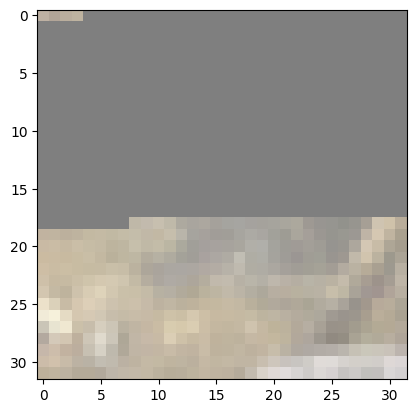

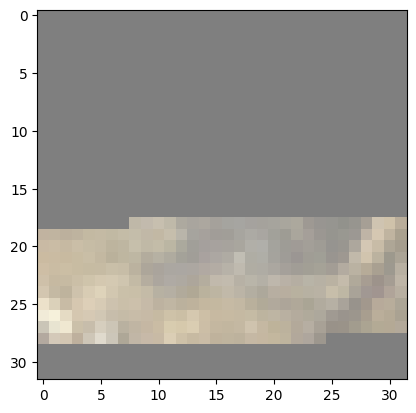

In [ ]:
# @title test multiblock params
import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_data)
img,y = next(dataiter)
img = img.unsqueeze(0)
b,c,h,w = img.shape
img = img.flatten(2).transpose(-2,-1).to(torch.bfloat16) # [b,c,h,w] -> [b,h*w,c]
print(img.shape)
batch, seq,_ = img.shape


# target_mask = randpatch(seq, mask_size=8, gamma=.9) # 8.9 [seq]
target_mask = multiblock(seq, min_s=0.2, max_s=0.3, M=4).any(0) # best.2.3M4 og.15.2M4# mask out targets to be predicted # [M, seq]
target_mask = multiblock(seq, min_s=0.2, max_s=0.3, M=4).any(0)

context_mask = ~multiblock(seq, min_s=0.85, max_s=1., M=1)|target_mask # [1, seq], True->Mask

# print(target_mask, context_mask)

print(target_mask.shape, context_mask.shape)
# target_img, context_img = img*target_mask.unsqueeze(-1), img*context_mask.unsqueeze(-1)
target_img, context_img = img*~target_mask.unsqueeze(-1), img*~context_mask.unsqueeze(-1)
# print(target_img.shape, context_img.shape)
target_img, context_img = target_img.transpose(-2,-1).reshape(b,c,h,w), context_img.transpose(-2,-1).reshape(b,c,h,w)
target_img, context_img = target_img.float(), context_img.float()

# imshow(out.detach().cpu())
imshow(target_img[0])
imshow(context_img[0])


In [ ]:

trg_msks = []
ctx_msks = []
for i in range(16):
    # target_mask = randpatch(seq, mask_size=8, gamma=.9) # 8.9 [seq]
    target_mask = multiblock(seq, min_s=0.2, max_s=0.3, M=4).any(0) # best.2.3M4 og.15.2M4# mask out targets to be predicted # [M, seq]
    target_mask = multiblock(seq, min_s=0.2, max_s=0.3, M=4).any(0)

    context_mask = ~multiblock(seq, min_s=0.85, max_s=1., M=1)|target_mask # [1, seq], True->Mask

    # print(target_mask.shape, context_mask.shape)
    target_img, context_img = img*~target_mask.unsqueeze(-1), img*~context_mask.unsqueeze(-1)
    target_img, context_img = target_img.transpose(-2,-1).reshape(b,c,h,w).float(), context_img.transpose(-2,-1).reshape(b,c,h,w).float()
    trg_msks.append(target_img)
    ctx_msks.append(context_img)

trg_msks = torch.cat(trg_msks, dim=0)
ctx_msks = torch.cat(ctx_msks, dim=0)
imshow(torchvision.utils.make_grid(trg_msks.cpu(), nrow=4))
imshow(torchvision.utils.make_grid(ctx_msks.cpu(), nrow=4))


In [ ]:
# @title test multiblock mask
def multiblock(seq, min_s, max_s, M=1): # https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
    mask_len = torch.rand(1) * (max_s - min_s) + min_s # in (min_s, max_s) # all blocks same size
    mask_pos = torch.rand(M) * (1 - mask_len) # in (0, 1 - mask_len)
    mask_len, mask_pos = (mask_len * seq).int(), mask_pos * seq
    # mask_len, mask_pos = mask_len * seq, mask_pos * seq
    indices = torch.arange(seq).unsqueeze(0) # [1, seq]
    target_mask = (indices >= mask_pos.unsqueeze(-1)) & (indices < (mask_pos + mask_len).unsqueeze(-1)) # [M, seq]
    return target_mask


seq=400
M=4

# target_mask = multiblock(M, seq, min_s=0.15, max_s=0.2, M=1) # mask out targets to be predicted # [4*batch, seq]
# context_mask = ~multiblock(1, seq, min_s=0.85, max_s=1., M=1)|target_mask.reshape(M,seq).any(0) # [batch, seq]


target_mask = multiblock(seq, min_s=0.15, max_s=0.2, M=4) # mask out targets to be predicted # [4*batch, seq]
context_mask = ~multiblock(seq, min_s=0.85, max_s=1., M=1)|target_mask.reshape(M,seq).any(0) # [batch, seq]

# target_mask, context_mask = target_mask.to(device), context_mask.to(device)

# print(target_mask)
# print(context_mask)

print(target_mask.sum(-1))
print(context_mask.sum(-1))


# sorted_mask, ids = context_mask.sort(dim=1, stable=True)
# indices = ids[~sorted_mask]#.reshape(M,-1) # int idx [num_context_toks] , idx of context not masked
# sorted_x = x[torch.arange(batch).unsqueeze(-1), indices] # [batch, seq-num_trg_toks, dim]
# print(indices)
# print(x)
# print(sorted_x)



# sorted_mask, ids = target_mask.sort(dim=1, descending=False, stable=True)
# # print(sorted_mask, ids)
# indices = ids[~sorted_mask].reshape(M,-1) # int idx [M, seq-num_trg_toks] , idx of target not masked
# print(indices)
# batch=3
# dim=2
# # indices = indices.expand(batch,-1,-1)
# # x = torch.arange(batch*seq).reshape(batch,seq).to(device)
# x = torch.rand(batch, seq, dim)
# print(x)
# sorted_x = x[torch.arange(batch)[...,None,None], indices]
# print(sorted_x.shape) # [batch, M, seq-num_trg_toks, dim]
# print(sorted_x)



tensor([73, 73, 73, 73])
tensor([248])


In [ ]:
# @title ijepa multiblock down
# https://github.com/facebookresearch/ijepa/blob/main/src/masks/multiblock.py
import math
from multiprocessing import Value
import torch
_GLOBAL_SEED = 0


class MaskCollator(object):
    def __init__(
        self,
        input_size=(224, 224),
        patch_size=16,
        enc_mask_scale=(0.2, 0.8),
        pred_mask_scale=(0.2, 0.8),
        aspect_ratio=(0.3, 3.0),
        nenc=1,
        npred=2,
        min_keep=4,
        allow_overlap=False
    ):
        super().__init__()
        if not isinstance(input_size, tuple):
            input_size = (input_size, ) * 2
        self.patch_size = patch_size
        self.height, self.width = input_size[0] // patch_size, input_size[1] // patch_size
        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.aspect_ratio = aspect_ratio
        self.nenc = nenc
        self.npred = npred
        self.min_keep = min_keep  # minimum number of patches to keep
        self.allow_overlap = allow_overlap  # whether to allow overlap b/w enc and pred masks
        self._itr_counter = Value('i', -1)  # collator is shared across worker processes

    def step(self):
        i = self._itr_counter
        with i.get_lock():
            i.value += 1
            v = i.value
        return v

    def _sample_block_size(self, generator, scale, aspect_ratio_scale):
        _rand = torch.rand(1, generator=generator).item()
        # -- Sample block scale
        min_s, max_s = scale
        mask_scale = min_s + _rand * (max_s - min_s)
        max_keep = int(self.height * self.width * mask_scale)
        # -- Sample block aspect-ratio
        min_ar, max_ar = aspect_ratio_scale
        aspect_ratio = min_ar + _rand * (max_ar - min_ar)
        # -- Compute block height and width (given scale and aspect-ratio)
        h = int(round(math.sqrt(max_keep * aspect_ratio)))
        w = int(round(math.sqrt(max_keep / aspect_ratio)))
        while h >= self.height:
            h -= 1
        while w >= self.width:
            w -= 1

        return (h, w)

    def _sample_block_mask(self, b_size, acceptable_regions=None):
        h, w = b_size

        def constrain_mask(mask, tries=0):
            """ Helper to restrict given mask to a set of acceptable regions """
            N = max(int(len(acceptable_regions)-tries), 0)
            for k in range(N):
                mask *= acceptable_regions[k]
        # --
        # -- Loop to sample masks until we find a valid one
        tries = 0
        timeout = og_timeout = 20
        valid_mask = False
        while not valid_mask:
            # -- Sample block top-left corner
            top = torch.randint(0, self.height - h, (1,))
            left = torch.randint(0, self.width - w, (1,))
            mask = torch.zeros((self.height, self.width), dtype=torch.int32)
            mask[top:top+h, left:left+w] = 1
            # -- Constrain mask to a set of acceptable regions
            if acceptable_regions is not None:
                constrain_mask(mask, tries)
            mask = torch.nonzero(mask.flatten())
            # -- If mask too small try again
            valid_mask = len(mask) > self.min_keep
            if not valid_mask:
                timeout -= 1
                if timeout == 0:
                    tries += 1
                    timeout = og_timeout
        mask = mask.squeeze()
        # --
        mask_complement = torch.ones((self.height, self.width), dtype=torch.int32)
        mask_complement[top:top+h, left:left+w] = 0
        # --
        return mask, mask_complement

    def __call__(self, batch):
        '''
        Create encoder and predictor masks when collating imgs into a batch
        # 1. sample enc block (size + location) using seed
        # 2. sample pred block (size) using seed
        # 3. sample several enc block locations for each image (w/o seed)
        # 4. sample several pred block locations for each image (w/o seed)
        # 5. return enc mask and pred mask
        '''
        B = len(batch)

        collated_batch = torch.utils.data.default_collate(batch)

        seed = self.step()
        g = torch.Generator()
        g.manual_seed(seed)
        p_size = self._sample_block_size(
            generator=g,
            scale=self.pred_mask_scale,
            aspect_ratio_scale=self.aspect_ratio)
        e_size = self._sample_block_size(
            generator=g,
            scale=self.enc_mask_scale,
            aspect_ratio_scale=(1., 1.))

        collated_masks_pred, collated_masks_enc = [], []
        min_keep_pred = self.height * self.width
        min_keep_enc = self.height * self.width
        for _ in range(B):

            masks_p, masks_C = [], []
            for _ in range(self.npred):
                mask, mask_C = self._sample_block_mask(p_size)
                masks_p.append(mask)
                masks_C.append(mask_C)
                min_keep_pred = min(min_keep_pred, len(mask))
            collated_masks_pred.append(masks_p)

            acceptable_regions = masks_C
            try:
                if self.allow_overlap:
                    acceptable_regions= None
            except Exception as e:
                print(f'Encountered exception in mask-generator {e}')

            masks_e = []
            for _ in range(self.nenc):
                mask, _ = self._sample_block_mask(e_size, acceptable_regions=acceptable_regions)
                masks_e.append(mask)
                min_keep_enc = min(min_keep_enc, len(mask))
            collated_masks_enc.append(masks_e)

        collated_masks_pred = [[cm[:min_keep_pred] for cm in cm_list] for cm_list in collated_masks_pred]
        collated_masks_pred = torch.utils.data.default_collate(collated_masks_pred)
        # --
        collated_masks_enc = [[cm[:min_keep_enc] for cm in cm_list] for cm_list in collated_masks_enc]
        collated_masks_enc = torch.utils.data.default_collate(collated_masks_enc)

        return collated_batch, collated_masks_enc, collated_masks_pred





## pamap trash

In [ ]:
# @title test WISDM

# print(activity_dataframe)
# print(activity_dataframe['activity'])
# activity_dataframe.to_csv('data.csv',index=False)

# data = pd.read_csv("/data.csv", index_col ="Name")
# data = pd.read_csv("data.csv")

# a = list(activity_dataframe['timestamp'])
# print(a)
# print([x-y for x,y in zip(a[1:],a[:-1])])

# print(data.loc[0])
# p = data.loc[0]
# print(len(p))
# ID, activity, timestamp, x, y, z, meter, device = data.loc[0]
# print(activity)

# print(data.loc[1639])

# userids = data['ID'].unique()#for id in userids
# print(data['activity'].unique())
# df_keep = data[['ID','activity','timestamp','x','y','z']]


# grouped = df_keep.groupby(['ID'])
# grouped = df_keep.groupby(['ID','activity'])
# print(len(grouped))
# user_acts = dict(tuple(df_keep.groupby(['ID','activity'])))
# print(user_acts)
# print(len(user_acts))
# temp_df = df[df['ID'] == id]

# print(len(df_keep))
# print(len(data))



# act = [[a, d[['timestamp','x','y','z']].to_numpy()] for a, d in user_acts.items()]
# act = [[(int(a[0]), ), d[['timestamp','x','y','z']].to_numpy()] for a, d in user_acts.items()]
# print(act)
# print(act[0])
# # print(act[0][1])
# print(len(act[1]))
# print([len(a[1]) for a in act])
# print(min([len(a[1]) for a in act])) # 3567


# act_dict = {i: act for i, act in enumerate(data['activity'].unique())}
# act_invdict = {v: k for k, v in act_dict.items()}
# print(act_invdict)

# torch.tensor(act[0][1][:3500])

# id_act, x = act[0]
# id_act = self.process(id_act)
# return id_act,
# torch.tensor(x[:3500]) # 3567


# /content/processed/wisdm-dataset/raw/phone/accel/data.csv
# /content/processed/wisdm-dataset/raw/watch/gyro/data.csv

# data0 = pd.read_csv("/content/processed/wisdm-dataset/raw/watch/accel/data.csv")
# data1 = pd.read_csv("/content/processed/wisdm-dataset/raw/watch/gyro/data.csv")

# user_acts0 = dict(tuple(data0.groupby(['ID','activity'])))
# user_acts1 = dict(tuple(data1.groupby(['ID','activity'])))

for (a0,d0), (a1,d1) in zip(user_acts0.items(), user_acts1.items()):
    print(a0,a1)
    print(len(d0),len(d1))



In [ ]:
# @title har_cnn
# https://arxiv.org/pdf/2209.08335v1
# https://github.com/Lou1sM/HAR/blob/master/har_cnn.py
import sys
import json
from hmmlearn import hmm
from copy import deepcopy
import os
import math
from pdb import set_trace
import torch
import torch.nn as nn
import numpy as np
import time
from torch.utils import data
import cl_args
from dl_utils.misc import asMinutes,check_dir
#from dl_utils.label_funcs import accuracy, mean_f1, debable, translate_labellings, get_num_labels, label_counts, dummy_labels, avoid_minus_ones_lf_wrapper,masked_mode,acc_by_label, get_trans_dict
from label_funcs_tmp import accuracy, mean_f1, translate_labellings, get_num_labels, label_counts, dummy_labels, avoid_minus_ones_lf_wrapper,masked_mode,acc_by_label, get_trans_dict
from dl_utils.tensor_funcs import noiseify, numpyify, cudify
from make_dsets import make_single_dset, make_dsets_by_user
from sklearn.metrics import normalized_mutual_info_score,adjusted_rand_score
from sklearn.mixture import GaussianMixture
from project_config import get_dataset_info_object

rari = lambda x,y: round(adjusted_rand_score(x,y),4)
rnmi = lambda x,y: round(normalized_mutual_info_score(x,y),4)

class EncByLayer(nn.Module):
    def __init__(self,x_filters,y_filters,x_strides,y_strides,max_pools,show_shapes):
        super().__init__()
        self.show_shapes = show_shapes
        num_layers = len(x_filters)
        assert all(len(x)==num_layers for x in (y_filters,x_strides,y_strides,max_pools))
        ncvs = [1]+[4*2**i for i in range(num_layers)]
        # conv_layers = []
        # for i in range(num_layers):
        #     conv_layer = nn.Sequential(
        #         nn.Conv2d(ncvs[i],ncvs[i+1],(x_filters[i],y_filters[i]),(x_strides[i],y_strides[i])), nn.BatchNorm2d(ncvs[i+1]) if i<num_layers-1 else nn.Identity(), nn.LeakyReLU(0.3), nn.MaxPool2d(max_pools[i])
        #     )
        #     conv_layers.append(conv_layer)
        # self.conv_layers = nn.ModuleList(conv_layers)

        self.conv_layers = nn.Sequential(*[
                nn.Conv2d(ncvs[i],ncvs[i+1],(x_filters[i],y_filters[i]),(x_strides[i],y_strides[i])), nn.BatchNorm2d(ncvs[i+1]) if i<num_layers-1 else nn.Identity(), nn.LeakyReLU(0.3), nn.MaxPool2d(max_pools[i])
             for i in range(nlayers)])


    def forward(self,x):
        # if self.show_shapes: print(x.shape)
        # for conv_layer in self.conv_layers:
        x = conv_layer(x)
            # if self.show_shapes: print(x.shape)
        return x

class DecByLayer(nn.Module):
    def __init__(self,x_filters,y_filters,x_strides,y_strides,show_shapes):
        super().__init__()
        self.show_shapes = show_shapes
        num_layers = len(x_filters)
        assert all(len(x)==num_layers for x in (y_filters,x_strides,y_strides))
        ncvs = [4*2**i for i in reversed(range(num_layers))]+[1]
        conv_trans_layers = [nn.Sequential(
                nn.ConvTranspose2d(ncvs[i],ncvs[i+1],(x_filters[i],y_filters[i]),(x_strides[i],y_strides[i])), nn.BatchNorm2d(ncvs[i+1]), nn.LeakyReLU(0.3),
                )
            for i in range(num_layers)]
        self.conv_trans_layers = nn.ModuleList(conv_trans_layers)

    def forward(self,x):
        if self.show_shapes: print(x.shape)
        for conv_trans_layer in self.conv_trans_layers:
            x = conv_trans_layer(x)
            if self.show_shapes: print(x.shape)
        return x

class Var_BS_MLP(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(input_size,hidden_size), nn.BatchNorm1d(hidden_size), nn.LeakyReLU(0.3), nn.Linear(hidden_size,output_size))

    def forward(self,x):
        return self.mlp(x)


def main(args):
    os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    dset_info_object = get_dataset_info_object(args.dset)
    num_classes = args.num_classes if args.num_classes != -1 else dset_info_object.num_classes
    if args.dset == 'UCI_feat':
        enc = nn.Sequential(nn.Linear(561,500),nn.ReLU(),
                            nn.Linear(500,500),nn.ReLU(),
                            nn.Linear(500,2000),nn.ReLU(),
                            nn.Linear(2000,6),nn.ReLU()).cuda()
        dec = nn.Sequential(nn.Linear(6,2000),nn.ReLU(),
                            nn.Linear(2000,500),nn.ReLU(),
                            nn.Linear(500,500),nn.ReLU(),
                            nn.Linear(500,561),nn.ReLU()).cuda()
        mlp = Var_BS_MLP(6,256,num_classes).cuda()
    else:
        if args.window_size == 512:
            x_filters = (50,40,7,4)
            x_strides = (2,2,1,1)
            max_pools = ((2,1),(2,1),(2,1),(2,1))
        elif args.window_size == 100:
            x_filters = (20,20,5,3)
            x_strides = (1,1,1,1)
            max_pools = ((2,1),(2,1),(2,1),1)
        y_filters = (1,1,1,dset_info_object.num_channels)
        y_strides = (1,1,1,1)
        enc = EncByLayer(x_filters,y_filters,x_strides,y_strides,max_pools,show_shapes=args.show_shapes).cuda()
        #if args.is_n2d:
        x_filters_trans = (15,10,15,11)
        x_strides_trans = (2,3,3,3)
        y_filters_trans = (dset_info_object.num_channels,1,1,1)
        dec = DecByLayer(x_filters_trans,y_filters_trans,x_strides_trans,y_strides,show_shapes=args.show_shapes).cuda()

        optional_umap_like_net_in = Var_BS_MLP(32,256,2).cuda()
        optional_umap_like_net_out = Var_BS_MLP(2,256,2).cuda()
        if ARGS.is_uln:
            enc = nn.Sequential(enc,nn.Flatten(1),Var_BS_MLP(32,256,2).cuda())
            dec = nn.Sequential(Var_BS_MLP(32,256,2).cuda(),nn.Unflatten(2,(32,1,1)),dec)
        mlp = Var_BS_MLP(2 if ARGS.is_uln else 32,256,num_classes).cuda()
    if args.load_pretrained:
        enc.load_state_dict(torch.load('enc_pretrained.pt'))
    subj_ids = args.subj_ids

    metric_dict = {'acc':accuracy,'nmi':rnmi,'ari':rari,'f1':mean_f1}
    har = HARLearner(enc=enc,mlp=mlp,dec=dec,num_classes=num_classes,args=args,metric_dict=metric_dict)

    start_time = time.time()
    already_exists = check_dir(f"experiments/{args.exp_name}/preds")
    check_dir(f"experiments/{args.exp_name}/best_preds")
    if args.show_shapes:
        dset_train, selected_acts = make_single_dset(args,subj_ids)
        num_ftrs = dset_train.x.shape[-1]
        print(num_ftrs)
        lat = enc(torch.ones((2,1,args.window_size,num_ftrs),device='cuda'))
        dec(lat)
        sys.exit()
    dsets_by_id = make_dsets_by_user(args,subj_ids)
    if args.is_n2d:
        for subj_id, (dset,sa) in dsets_by_id.items():
            print("n2ding", subj_id)
            har.n2d_abl(subj_id,dset)
    elif not args.subject_independent:
        bad_ids = []
        for user_id, (dset,sa) in dsets_by_id.items():
            n = get_num_labels(dset.y)
            if n < dset_info_object.num_classes/2:
                print(f"Excluding user {user_id}, only has {n} different labels, out of {num_classes}")
                bad_ids.append(user_id)
        if not args.bad_ids: dsets_by_id = {k:v for k,v in dsets_by_id.items() if k not in bad_ids}
        print('reloading clusterings for', [x for x in subj_ids[:args.reload_ids] if x not in bad_ids])
        for rid in subj_ids[:args.reload_ids]:
            if rid in bad_ids: continue
            print('reloading clusterings for', rid)
            rdset,sa = dsets_by_id.pop(rid)
            best_preds = np.load(f'experiments/{args.exp_name}/best_preds/{rid}.npy')
            preds = np.load(f'experiments/{args.exp_name}/preds/{rid}.npy')
            har.log_preds_and_scores(rid,preds,best_preds,numpyify(rdset.y))
        print('clustering remaining ids', [x for x in subj_ids[args.reload_ids:]], 'from scratch\n')

        print("CLUSTERING EACH DSET SEPARATELY")
        for subj_id, (dset,sa) in dsets_by_id.items():
            print("clustering", subj_id)
            har.pseudo_label_cluster_meta_meta_loop(subj_id,dset)
    elif args.subject_independent:
        print("CLUSTERING AS SINGLE DSET")
        one_big_dset, selected_acts = make_single_dset(args,subj_ids)
        har.pseudo_label_cluster_meta_meta_loop('all',one_big_dset)

    results_file_path = f'experiments/{args.exp_name}/results.txt'
    har.total_time = time.time() - start_time
    har.log_final_scores(results_file_path)
    har.express_times(results_file_path)


if __name__ == "__main__":

    ARGS, need_umap = cl_args.get_cl_args()
    if need_umap: import umap
    main(ARGS)


In [ ]:
# @title Lou1sM download_datasets.sh
# https://github.com/Lou1sM/HAR/blob/master/download_datasets.sh

##!/bin/sh

mkdir -p datasets
cd datasets

#PAMAP
# echo -e "\n###############"
# echo GETTING AND PREPARING PAMAP DATA
# echo -e "###############\n"
wget http://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
unzip PAMAP2_Dataset.zip
# python ../convert_data_to_np.py PAMAP

#UCI
# echo -e "\n###############"
# echo GETTING AND PREPARING UCI DATA
# echo -e "###############\n"
mkdir -p UCI2
cd UCI2
wget http://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip
unzip HAPT\ Data\ Set.zip
# cd ..
# python ../convert_data_to_np.py UCI-raw

#mkdir -p capture24
#cd capture24/

#for i in $(seq -w 151)
#do
#    curl -JLO "https://ora.ox.ac.uk/objects/uuid:92650814-a209-4607-9fb5-921eab761c11/download_file?safe_filename=P${i}.csv.gz&type_of_work=Dataset"
#done
#
#curl -JLO "https://ora.ox.ac.uk/objects/uuid:92650814-a209-4607-9fb5-921eab761c11/download_file?safe_filename=metadata.csv&type_of_work=Dataset"
#curl -JLO "https://ora.ox.ac.uk/objects/uuid:92650814-a209-4607-9fb5-921eab761c11/download_file?safe_filename=annotation-label-dictionary.csv&type_of_work=Dataset"
#
#
#for f in $(ls); do
#    if [ ${f: -2} == "gz" ]; then
#        gunzip $f;
#    fi;
#done

#WISDM-v1
# echo -e "\n###############"
# echo GETTING AND PREPARING WISDM-v1 DATA
# echo -e "###############\n"
wget https://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
gunzip WISDM_ar_latest.tar.gz
tar -xf WISDM_ar_latest.tar

# python ../convert_data_to_np.py WISDM-v1

#WISDM-watch
# echo -e "\n###############"
# echo GETTING AND PREPARING WISDM-watch DATA
# echo -e "###############\n"
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip
unzip wisdm-dataset.zip
python ../convert_data_to_np.py WISDM-watch

#REALDISP
# echo -e "\n###############"
# echo GETTING REALDISP DATA
# echo -e "###############\n"
mkdir -p realdisp
cd realdisp
mkdir -p RawData
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00305/realistic_sensor_displacement.zip
unzip realistic_sensor_displacement.zip
# cd ..
# python ../convert_data_to_np.py REALDISP
# cd ..
# pwd
#HHAR
mkdir -p hhar
wget http://archive.ics.uci.edu/ml/machine-learning-databases/00344/Activity%20recognition%20exp.zip
unzip Activity\ recognition\ exp.zip
# python ../convert_data_to_np.py HHAR
# cd ..


SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-1-94e7ebe34632>, line 10)

In [ ]:
# @title PAMAP2
# https://arxiv.org/pdf/2209.08335v1
# https://archive.ics.uci.edu/dataset/231/pamap2+physical+activity+monitoring
# https://archive.ics.uci.edu/static/public/231/pamap2+physical+activity+monitoring.zip
# !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00231/PAMAP2_Dataset.zip
# !unzip PAMAP2_Dataset.zip

import os
data_dir = 'PAMAP2_Dataset/Protocol'
np_dir = '/content/PAMAP2'
if not os.path.isdir(np_dir):
    os.makedirs(np_dir)



import os
import numpy as np

def array_from_txt(inpath):
    with open(inpath) as f:
        d = f.readlines()
        array = np.array([[float(x) for x in line.split()] for line in d])
    return array

def array_expanded(a,expanded_length):
    if a.shape[0] >= expanded_length: return a
    insert_every = mpf(a.shape[0]/(expanded_length-a.shape[0]))
    additional_idxs = (np.arange(expanded_length-a.shape[0])*insert_every).astype(np.int)
    values = a[additional_idxs]
    expanded = np.insert(a,additional_idxs,values,axis=0)
    assert expanded.shape[0] == expanded_length
    return expanded

def convert(inpath,outpath):
    array = array_from_txt(inpath)
    timestamps = array[:,0]
    labels = array[:,1].astype(int)
    # Delete orientation data, which webpage says is 'invalid in this data, and timestamp and label
    array = np.delete(array,[0,1,2,13,14,15,16,30,31,32,33,47,48,49,50],1)
    np.save(outpath+'_timestamps',timestamps)
    np.save(outpath+'_labels',labels)
    np.save(outpath,array)

for filename in os.listdir(data_dir):
    print(data_dir,filename)
    # inpath = os.path.join(data_dir,filename)a
    inpath = data_dir+'/'+filename
    outpath = np_dir+'/'+filename.split('.')[0]
    print(outpath)
    # outpath = os.path.join(np_dir,filename.split('.')[0])
    convert(inpath,outpath)


PAMAP2_Dataset/Protocol subject106.dat
/content/PAMAP2/subject106
PAMAP2_Dataset/Protocol subject101.dat
/content/PAMAP2/subject101
PAMAP2_Dataset/Protocol subject107.dat
/content/PAMAP2/subject107
PAMAP2_Dataset/Protocol subject109.dat
/content/PAMAP2/subject109
PAMAP2_Dataset/Protocol subject103.dat
/content/PAMAP2/subject103
PAMAP2_Dataset/Protocol subject104.dat
/content/PAMAP2/subject104
PAMAP2_Dataset/Protocol subject108.dat
/content/PAMAP2/subject108
PAMAP2_Dataset/Protocol subject105.dat
/content/PAMAP2/subject105
PAMAP2_Dataset/Protocol subject102.dat
/content/PAMAP2/subject102


In [ ]:

# def make_pamap_dset_train_val(args,subj_ids):
def make_pamap_dset_train_val(subj_ids):
    # dset_info_object = PAMAP_INFO.PAMAP_INFO
    dset_info_object = PAMAP_INFO
    # x_train = np.concatenate([np.load(f'datasets/PAMAP2_Dataset/np_data/subject{s}.npy') for s in subj_ids])
    # y_train = np.concatenate([np.load(f'datasets/PAMAP2_Dataset/np_data/subject{s}_labels.npy') for s in subj_ids])
    x_train = np.concatenate([np.load(f'PAMAP2/subject{s}.npy') for s in subj_ids])
    y_train = np.concatenate([np.load(f'PAMAP2/subject{s}_labels.npy') for s in subj_ids])
    x_train = x_train[y_train!=0] # 0 is a transient activity
    y_train = y_train[y_train!=0] # 0 is a transient activity
    # x_train,y_train,selected_acts = preproc_xys(x_train,y_train,args.step_size,args.window_size,dset_info_object,subj_ids)
    x_train,y_train,selected_acts = preproc_xys(x_train,y_train,1,1,dset_info_object,subj_ids)
    # dset_train = StepDataset(x_train,y_train,window_size=args.window_size,step_size=args.step_size)
    # dset_train = StepDataset(x_train,y_train,window_size=512,step_size=5)
    dset_train = StepDataset(x_train,y_train,window_size=1,step_size=1)
    return dset_train, selected_acts

class HAR_Dataset_Container():
    def __init__(self,code_name,dataset_dir_name,possible_subj_ids,num_channels,num_classes,action_name_dict):
        self.code_name = code_name
        self.dataset_dir_name = dataset_dir_name
        self.possible_subj_ids = possible_subj_ids
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.action_name_dict = action_name_dict


# PAMAP
pamap_ids = [str(x) for x in range(101,110)]
pamap_action_name_dict = {1:'lying',2:'sitting',3:'standing',4:'walking',5:'running',6:'cycling',7:'Nordic walking',9:'watching TV',10:'computer work',11:'car driving',12:'ascending stairs',13:'descending stairs',16:'vacuum cleaning',17:'ironing',18:'folding laundry',19:'house cleaning',20:'playing soccer',24:'rope jumping'}
PAMAP_INFO = HAR_Dataset_Container(
            code_name = 'PAMAP',
            dataset_dir_name = 'PAMAP2_Dataset',
            possible_subj_ids = pamap_ids,
            num_channels = 39,
            num_classes = 12,
            action_name_dict = pamap_action_name_dict)

dset_train, selected_acts = make_pamap_dset_train_val(pamap_ids)


no precomputed datasets, computing from scratch


IndexError: invalid index to scalar variable.

In [ ]:
# @title Lou1sM convert_data_to_np.py
# https://github.com/Lou1sM/HAR/blob/master/convert_data_to_np.py
from pdb import set_trace
from collections import Counter
from scipy.fft import fft
from scipy import stats
from mpmath import mp, mpf
#from dl_utils import misc, label_funcs
# from dl_utils import misc
# import label_funcs_tmp
import os
from os.path import join
import sys
import numpy as np
import pandas as pd
import json

def array_from_txt(inpath):
    with open(inpath) as f:
        d = f.readlines()
        array = np.array([[float(x) for x in line.split()] for line in d])
    return array

def array_expanded(a,expanded_length):
    if a.shape[0] >= expanded_length: return a
    insert_every = mpf(a.shape[0]/(expanded_length-a.shape[0]))
    additional_idxs = (np.arange(expanded_length-a.shape[0])*insert_every).astype(np.int)
    values = a[additional_idxs]
    expanded = np.insert(a,additional_idxs,values,axis=0)
    assert expanded.shape[0] == expanded_length
    return expanded

def convert(inpath,outpath):
    array = array_from_txt(inpath)
    timestamps = array[:,0]
    labels = array[:,1].astype(np.int)
    # Delete orientation data, which webpage says is 'invalid in this data, and timestamp and label
    array = np.delete(array,[0,1,2,13,14,15,16,30,31,32,33,47,48,49,50],1)
    np.save(outpath+'_timestamps',timestamps)
    np.save(outpath+'_labels',labels)
    np.save(outpath,array)

def expand_and_fill_labels(a,propoer_length):
    start_filler = -np.ones(a[0,3])
    end_filler = -np.ones(propoer_length-a[-1,4])
    nested_lists = [[a[i,2] for _ in range(a[i,4]-a[i,3])] + [-1]*(a[i+1,3]-a[i,4]) for i in range(len(a)-1)] + [[a[-1,2] for _ in range(a[-1,4]-a[-1,3])]]
    middle = np.array([item for sublist in nested_lists for item in sublist])
    total_label_array = np.concatenate((start_filler,middle,end_filler)).astype(np.int)
    return total_label_array

def add_dtft(signal):
    fft_signal_complex = fft(signal,axis=-1)
    fft_signal_modulusses = np.abs(fft_signal_complex)
    return np.concatenate((signal,fft_signal_modulusses),axis=-1)

# if __name__ == "__main__":
# if sys.argv[1] == 'PAMAP':
data_dir = 'PAMAP2_Dataset/Protocol'
np_dir = 'PAMAP2_Dataset/np_data'
print("\n#####Preprocessing PAMAP2#####\n")
if not os.path.isdir(np_dir):
    os.makedirs(np_dir)

for filename in os.listdir(data_dir):
    print(filename)
    inpath = join(data_dir,filename)
    outpath = join(np_dir,filename.split('.')[0])
    convert(inpath,outpath)

# elif sys.argv[1] == 'UCI-raw':
data_dir = 'UCI2/RawData'
np_dir = 'UCI2/np_data'
print("\n#####Preprocessing UCI#####\n")
if not os.path.isdir(np_dir):
    os.makedirs(np_dir)

raw_label_array = array_from_txt(join(data_dir,'labels.txt')).astype(int)
def two_digitify(x): return '0'+str(x) if len(str(x))==1 else str(x)
fnames = os.listdir(data_dir)
for idx in range(1,31):
    print("processing user",idx)
    acc_array_list = []
    gyro_array_list = []
    label_array_list = []
    user_idx = two_digitify(idx)
    acc_fpaths = sorted([fn for fn in fnames if f'user{user_idx}' in fn and 'acc' in fn])
    gyro_fpaths = sorted([fn for fn in fnames if f'user{user_idx}' in fn and 'gyro' in fn])
    assert len(acc_fpaths) == len(gyro_fpaths)
    for fna,fng in zip(acc_fpaths,gyro_fpaths):
        acc_exp_id = int(fna.split('exp')[1][:2])
        gyro_exp_id = int(fng.split('exp')[1][:2])
        assert acc_exp_id==gyro_exp_id
        new_acc_array = array_from_txt(join(data_dir,fna))
        new_gyro_array = array_from_txt(join(data_dir,fna))
        label_array_block = raw_label_array[raw_label_array[:,0]==acc_exp_id]
        filled_label_array_block = expand_and_fill_labels(label_array_block,new_acc_array.shape[0])
        assert filled_label_array_block.shape[0] == new_acc_array.shape[0]
        assert filled_label_array_block.shape[0] == new_gyro_array.shape[0]
        label_array_list.append(filled_label_array_block)
        acc_array_list.append(new_acc_array)
        gyro_array_list.append(new_gyro_array)
    label_array = np.concatenate(label_array_list)
    acc_array = np.concatenate(acc_array_list)
    gyro_array = np.concatenate(gyro_array_list)
    total_array = np.concatenate((acc_array,gyro_array),axis=1)
    outpath = join(np_dir,f'user{user_idx}.npy')
    np.save(outpath,total_array)
    label_outpath = join(np_dir,f'user{user_idx}_labels.npy')
    np.save(label_outpath,label_array)

# elif sys.argv[1] == 'WISDM-v1':
with open('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt') as f: text = f.readlines()
print("\n#####Preprocessing WISDM-v1#####\n")
activities_list = ['Jogging','Walking','Upstairs','Downstairs','Standing','Sitting']
X_list = []
y_list = []
users_list = []
num_zeros = 0
def process_line(line_to_process):
    global num_zeros
    if float(line_to_process.split(',')[2]) == 0: num_zeros += 1#print("Timestamp zero, discarding")
    else:
        X_list.append([float(x) for x in line_to_process.split(',')[3:]])
        y_list.append(activities_list.index(line_to_process.split(',')[1]))
        users_list.append(line_to_process.split(',')[0])
for i,raw_line in enumerate(text):
    #line = line.replace(';','').replace('\n','')
    if raw_line == '\n': continue
    elif raw_line.endswith(',;\n'): line = raw_line[:-3]
    elif raw_line.endswith(';\n'): line = raw_line[:-2]
    elif raw_line.endswith(',\n'): line = raw_line[:-2]
    else: set_trace()
    if len(line.split(',')) == 6:
        try: process_line(line)
        except: print(f"Can't process line {i}, even though length 6: {raw_line}\n")
    else:
        print(f"Bad format at line {i}:\n{raw_line}")
        try:
            line1, line2 = line.split(';')
            process_line(line1); process_line(line2)
            print(f"I think this was two lines erroneously put on one line. Processing separately as\n{line1}\nand\n{line2}")
        except: print("Can't process this line at all, omitting")
one_big_X_array = np.array(X_list)
one_big_y_array = np.array(y_list)
one_big_users_array = np.array(users_list)
print(one_big_X_array.shape)
print(one_big_y_array.shape)
print(one_big_users_array.shape)
print(f"Number of zero lines: {num_zeros}")
misc.np_save(one_big_X_array,'wisdm_v1','X.npy')
misc.np_save(one_big_y_array,'wisdm_v1','y.npy')
misc.np_save(one_big_users_array,'wisdm_v1','users.npy')

# elif sys.argv[1] == 'WISDM-watch':
p_dir = 'wisdm-dataset/raw/phone'
w_dir = 'wisdm-dataset/raw/watch'
np_dir = 'wisdm-dataset/np_data'
print("\n#####Preprocessing WISDM-watch#####\n")
if not os.path.isdir(np_dir):
    os.makedirs(np_dir)

mp.dps = 100 # Avoid floating point errors in label insertion function
for user_idx in range(1600,1651):
    print('user', user_idx)
    phone_acc_path = join(p_dir,'accel',f'data_{user_idx}_accel_phone.txt')
    watch_acc_path = join(w_dir,'accel',f'data_{user_idx}_accel_watch.txt')
    phone_gyro_path = join(p_dir,'gyro',f'data_{user_idx}_gyro_phone.txt')
    watch_gyro_path = join(w_dir,'gyro',f'data_{user_idx}_gyro_watch.txt')

    label_codes_list = list('ABCDEFGHIJKLMOPQRS') # Missin 'N' is deliberate
    def two_arrays_from_txt(inpath):
        with open(inpath) as f:
            d = f.readlines()
            arr = np.array([[float(x) for x in line.strip(';\n').split(',')[3:]] for line in d])
            label_array = np.array([label_codes_list.index(line.split(',')[1]) for line in d])
        return arr, label_array

    phone_acc, label_array1 = two_arrays_from_txt(phone_acc_path)
    watch_acc, label_array2 = two_arrays_from_txt(watch_acc_path)
    phone_gyro, label_array3 = two_arrays_from_txt(phone_gyro_path)
    watch_gyro, label_array4 = two_arrays_from_txt(watch_gyro_path)
    user_arrays = [phone_acc,watch_acc,phone_gyro,watch_gyro]
    label_arrays = [label_array1,label_array2,label_array3,label_array4]
    max_len = max([a.shape[0] for a in user_arrays])
    equalized_user_arrays = [array_expanded(a,max_len) for a in user_arrays]
    equalized_label_arrays = [array_expanded(lab_a,max_len) for lab_a in label_arrays]
    total_user_array = np.concatenate(equalized_user_arrays,axis=1)
    mode_object = stats.mode(np.stack(equalized_label_arrays,axis=1),axis=1)
    mode_labels = mode_object.mode[:,0]
    # Print how many windows contained just 1 label, how many 2 etc.
    #print('Agreement in labels:',label_funcs_tmp.label_counts(mode_object.count[:,0]))
    certains = (mode_object.count == 4)[:,0]
    user_fn = f'{user_idx}.npy'
    misc.np_save(total_user_array,np_dir,user_fn)
    user_labels_fn = f'{user_idx}_labels.npy'
    misc.np_save(mode_labels,np_dir,user_labels_fn)
    user_certains_fn = f'{user_idx}_certains.npy'
    misc.np_save(certains,np_dir,user_certains_fn)

# elif sys.argv[1] == 'REALDISP':
data_dir = 'realdisp/RawData'
np_dir = 'realdisp/np_data'
print("\n#####Preprocessing REALDISP#####\n")
if not os.path.isdir(np_dir):
    os.makedirs(np_dir)

for filename in os.listdir(data_dir):
    print(filename)
    if filename == 'dataset manual.pdf': continue
    if not filename.split('_')[1].startswith('ideal'):
        continue
    with open(join(data_dir,filename)) as f: xy = f.readlines()
    ar = np.array([[float(item) for item in line.split('\t')] for line in xy])
    x = ar[:,:-1]
    y = ar[:,-1].astype(int)

    np.save(join(np_dir,filename.split('_')[0]), x)
    np.save(join(np_dir,filename.split('_')[0])+'_labels', y)

# elif sys.argv[1] == 'Capture24':
np_dir = 'capture24/np_data'
if not os.path.isdir(np_dir):
    os.makedirs(np_dir)
name_df = pd.read_csv('capture24/annotation-label-dictionary.csv')
#name_conversion_dict = dict(zip(name_df['annotation'],name_df['label:DohertySpecific2018']))
name_df = name_df[['annotation','label:DohertySpecific2018']]
int_label_converter_df = pd.DataFrame(enumerate(name_df['label:DohertySpecific2018'].unique()),columns=['int_label','label:DohertySpecific2018'])
int_label_converter_dict = dict(enumerate(name_df['label:DohertySpecific2018'].unique()))
with open('capture24/int_label_converter_df.json','w') as f:
    json.dump(int_label_converter_dict,f)
name_df = name_df.merge(int_label_converter_df)
for fname in os.listdir('capture24'):
    if fname.endswith('.gz'): continue
    subj_id = fname.split('.')[0]
    if not subj_id.startswith('P') and not len(subj_id) == 4: continue # Skip metadata files
    print(f"converting {fname} to np")
    try: df = pd.read_csv(join('capture24',fname))
    except: set_trace()
    translated_df = df.merge(name_df)
    x = translated_df[['x','y','z']].to_numpy()
    y = translated_df['int_label'].to_numpy()
    np.save(join(np_dir,f'{subj_id}.npy'),x)
    np.save(join(np_dir,f'{subj_id}_labels.npy'),y)

# elif sys.argv[1] == 'HHAR':
data_dir = 'Activity recognition exp'
np_dir = 'hhar/np_data'
print("\n#####Preprocessing HHAR#####\n")
if not os.path.isdir(np_dir):
    os.makedirs(np_dir)

pandaload = lambda path: pd.read_csv(join(data_dir,'Phones_accelerometer.csv')).set_index('Creation_Time').drop(['Index','Arrival_Time','Model','Device'],axis=1).dropna()
print('loading dataframes\n')
phone_acc_df = pandaload('Phones_accelerometer.csv')
phone_gyro_df = pandaload('Phones_gyroscope.csv')
watch_acc_df = pandaload('Watch_accelerometer.csv')
watch_gyro_df = pandaload('Watch_gyroscope.csv')
activities_list = ['bike', 'sit', 'stand', 'walk', 'stairsup', 'stairsdown']
user_list = list('abcdefghi')

for user_letter_name in user_list:
    print('processing user', user_letter_name)
    user_phone_acc = phone_acc_df.loc[phone_acc_df.User==user_letter_name]
    user_phone_gyro = phone_gyro_df.loc[phone_gyro_df.User==user_letter_name]
    user_watch_acc = watch_acc_df.loc[watch_acc_df.User==user_letter_name]
    user_watch_gyro = watch_acc_df.loc[watch_gyro_df.User==user_letter_name]
    assert all([user_watch_gyro.shape==d.shape for d in (user_phone_acc,user_phone_gyro,user_watch_acc)])
    comb_phone = user_phone_acc.join(user_phone_gyro,how='outer',lsuffix='_acc',rsuffix='_gyro')
    comb_watch = user_watch_acc.join(user_watch_gyro,how='outer',lsuffix='_acc',rsuffix='_gyro')
    #if not (comb_watch.gt_acc == comb_watch.gt_gyro).all(): set_trace()
    #if not (comb_phone.gt_acc == comb_phone.gt_gyro).all(): set_trace()
    comb = comb_phone.join(comb_watch,how='outer',lsuffix='_phone',rsuffix='_watch')
    duplicate_rows = [x for x,count in Counter(comb.index).items() if count > 1]
    if len(duplicate_rows) > 10: set_trace()
    elif len(duplicate_rows) > 0:
        print( f"removing {len(duplicate_rows)} duplicate rows")
        comb = comb.drop(duplicate_rows)
    if not (comb.gt_acc_phone == comb.gt_acc_watch).all(): set_trace()
    user_X_array = comb.drop([c for c in comb.columns if 'User' in c or 'gt' in c],axis=1).to_numpy()
    user_y_array = np.array([activities_list.index(a) for a in comb['gt_acc_phone']])
    save_path = join(np_dir,f"{user_list.index(user_letter_name)+1}.npy")
    label_save_path = join(np_dir,f"{user_list.index(user_letter_name)+1}_labels.npy")
    np.save(save_path,user_X_array,allow_pickle=False)
    np.save(label_save_path,user_y_array,allow_pickle=False)
    # Make smaller option for testing
    np.save(join(np_dir,f"0.npy"),user_X_array[::1000],allow_pickle=False)
    np.save(join(np_dir,f"0_labels.npy"),user_y_array[::1000],allow_pickle=False)

else: print('\nIncorrect or no dataset specified\n')



Incorrect or no dataset specified



In [ ]:
# @title Lou1sM make_dsets.py
# https://github.com/Lou1sM/HAR/blob/master/make_dsets.py
import numpy as np
# from dl_utils.misc import check_dir, CifarLikeDataset
import os
import torch
# import project_config
from scipy import stats
from torch.utils import data
#from dl_utils import label_funcs
# from dl_utils.tensor_funcs import cudify
# import label_funcs_tmp
from pdb import set_trace
from os.path import join


class ChunkDataset(data.Dataset):
    def __init__(self,x,y):
        self.x, self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self,idx):
        batch_x = self.x[idx].unsqueeze(0)
        batch_y = self.y[idx]
        return batch_x, batch_y, idx

class ConcattedDataset(data.Dataset):
    """Needs datasets to be StepDatasets in order to Concat them."""
    def __init__(self,xs,ys,window_size,step_size):
        self.x, self.y = torch.cat(xs),torch.cat(ys)
        self.window_size = window_size
        self.step_size = step_size
        component_dset_lengths = [((len(x)-self.window_size)//self.step_size + 1) for x in xs]
        x_idx_locs = []
        block_start_idx = 0
        for x in xs:
            x_idx_locs += list(range(block_start_idx,block_start_idx+len(x)-window_size+1,step_size))
            block_start_idx += len(x)
        self.x_idx_locs = np.array(x_idx_locs)
        if not len(self.x_idx_locs) == len(self.y): set_trace()

    def __len__(self): return len(self.y)
    def __getitem__(self,idx):
        x_idx = self.x_idx_locs[idx]
        batch_x = self.x[x_idx:x_idx + self.window_size].unsqueeze(0)
        batch_y = self.y[idx]
        return batch_x, batch_y, idx

class UCIFeatDataset(data.Dataset):
    def __init__(self,x,y,transforms=[]):
        self.x, self.y = cudify(x).float(),cudify(y).float()
        assert len(self.x) == len(self.y)
        for transform in transforms:
            self.x = transform(self.x)
    def __len__(self): return len(self.x)
    def __getitem__(self,idx):
        batch_x = self.x[idx]
        batch_y = self.y[idx]
        return batch_x, batch_y, idx

class StepDataset(data.Dataset):
    def __init__(self,x,y,window_size,step_size,transforms=[]):
        self.x, self.y = cudify(x).float(),cudify(y).float()
        self.window_size = window_size
        self.step_size = step_size
        self.transforms = transforms
        self.position = None
        self.ensemble_size = None
        for transform in transforms:
            self.x = transform(self.x)
    def __len__(self): return (len(self.x)-self.window_size)//self.step_size + 1
    def __getitem__(self,idx):
        batch_x = self.x[idx*self.step_size:(idx*self.step_size) + self.window_size].unsqueeze(0)
        batch_y = self.y[idx]
        return batch_x, batch_y, idx

    def put_in_ensemble(self,position,ensemble_size):
        self.y += ensemble_size*position
        self.position = position
        self.ensemble_size = ensemble_size

def preproc_xys(x,y,step_size,window_size,dset_info_object,subj_ids):
    ids_string = 'all' if set(subj_ids) == set(dset_info_object.possible_subj_ids) else "-".join(subj_ids)
    precomp_dir = f'datasets/{dset_info_object.dataset_dir_name}/precomputed/{ids_string}step{step_size}_window{window_size}/'
    if os.path.isfile(join(precomp_dir,'x.pt')) and os.path.isfile(join(precomp_dir,'y.pt')):
        print("loading precomputed datasets")
        x = torch.load(join(precomp_dir,'x.pt'))
        y = torch.load(join(precomp_dir,'y.pt'))
        with open(join(precomp_dir,'selected_acts.txt')) as f: selected_acts = f.readlines()
    else:
        print("no precomputed datasets, computing from scratch")
        xnans = np.isnan(x).any(axis=1)
        x = x[~xnans]
        y = y[~xnans]
        x = x[y!=-1]
        y = y[y!=-1]
        num_windows = (len(x) - window_size)//step_size + 1
        #mode_labels = np.array([stats.mode(y[w*step_size:w*step_size + window_size]).mode[0] if (y[w*step_size:w*step_size + window_size]==y[w*step_size]).all() else -1 for w in range(num_windows)])
        mode_labels = np.array([stats.mode(y[w*step_size:w*step_size + window_size]).mode[0] for w in range(num_windows)])
        selected_ids = set(mode_labels)
        selected_acts = [dset_info_object.action_name_dict[act_id] for act_id in selected_ids]
        mode_labels, trans_dict, changed = label_funcs_tmp.compress_labels(mode_labels)
        assert len(selected_acts) == len(set(mode_labels))
        x = torch.tensor(x).float()
        y = torch.tensor(mode_labels).float()
        check_dir(precomp_dir)
        torch.save(x,join(precomp_dir,'x.pt'))
        torch.save(y,join(precomp_dir,'y.pt'))
        with open(join(precomp_dir,'selected_acts.txt'),'w') as f:
            for a in selected_acts: f.write(a+'\n')
    return x, y, selected_acts

def make_pamap_dset_train_val(args,subj_ids):
    # dset_info_object = project_config.PAMAP_INFO
    dset_info_object = PAMAP_INFO
    x_train = np.concatenate([np.load(f'datasets/PAMAP2_Dataset/np_data/subject{s}.npy') for s in subj_ids])
    y_train = np.concatenate([np.load(f'datasets/PAMAP2_Dataset/np_data/subject{s}_labels.npy') for s in subj_ids])
    x_train = x_train[y_train!=0] # 0 is a transient activity
    y_train = y_train[y_train!=0] # 0 is a transient activity
    x_train,y_train,selected_acts = preproc_xys(x_train,y_train,args.step_size,args.window_size,dset_info_object,subj_ids)
    dset_train = StepDataset(x_train,y_train,window_size=args.window_size,step_size=args.step_size)
    return dset_train, selected_acts

# def make_uci_dset_train_val(args,subj_ids):
#     dset_info_object = project_config.UCI_INFO
#     x_train = np.concatenate([np.load(f'datasets/UCI2/np_data/user{s}.npy') for s in subj_ids])
#     y_train = np.concatenate([np.load(f'datasets/UCI2/np_data/user{s}_labels.npy') for s in subj_ids])
#     x_train = x_train[y_train<7] # Labels still begin at 1 at this point as
#     y_train = y_train[y_train<7] # haven't been compressed, so select 1,..,6
#     #x_train = x_train[y_train!=-1]
#     #y_train = y_train[y_train!=-1]
#     #y_val = y_val[y_val!=-1]
#     x_train,y_train,selected_acts = preproc_xys(x_train,y_train,args.step_size,args.window_size,dset_info_object,subj_ids)
#     dset_train = StepDataset(x_train,y_train,window_size=args.window_size,step_size=args.step_size)
#     return dset_train, selected_acts

# def make_uci_feat_dset_train_val():
#     dset_info_object = project_config.UCI_INFO
#     x = np.load(f'datasets/UCI_feat/uci_feat_data.npy')
#     y = np.load(f'datasets/UCI_feat/uci_feat_targets.npy')
#     selected_acts = dict(enumerate(['walking','upstairs','downstairs','sitting','standing','lying']))
#     dset = UCIFeatDataset(x,y)
#     #dset.x = dset.data
#     #dset.y = dset.targets
#     return dset, selected_acts

# def make_wisdm_v1_dset_train_val(args,subj_ids):
#     dset_info_object = project_config.WISDMv1_INFO
#     x = np.load('datasets/wisdm_v1/X.npy')
#     y = np.load('datasets/wisdm_v1/y.npy')
#     users = np.load('datasets/wisdm_v1/users.npy')
#     train_idxs_to_user = np.zeros(users.shape[0]).astype(np.bool)
#     for subj_id in subj_ids:
#         new_users = users==subj_id
#         train_idxs_to_user = np.logical_or(train_idxs_to_user,new_users)
#     x_train = x[train_idxs_to_user]
#     y_train = y[train_idxs_to_user]
#     x_train,y_train,selected_acts = preproc_xys(x_train,y_train,args.step_size,args.window_size,dset_info_object,subj_ids)
#     dset_train = StepDataset(x_train,y_train,window_size=args.window_size,step_size=args.step_size)
#     return dset_train, selected_acts

# def make_wisdm_watch_dset_train_val(args,subj_ids):
#     dset_info_object = project_config.WISDMwatch_INFO
#     x_train = np.concatenate([np.load(f'datasets/wisdm-dataset/np_data/{s}.npy') for s in subj_ids])
#     y_train = np.concatenate([np.load(f'datasets/wisdm-dataset/np_data/{s}_labels.npy') for s in subj_ids])
#     certains_train = np.concatenate([np.load(f'datasets/wisdm-dataset/np_data/{s}_certains.npy') for s in subj_ids])
#     x_train = x_train[certains_train]
#     y_train = y_train[certains_train]
#     x_train,y_train,selected_acts = preproc_xys(x_train,y_train,args.step_size,args.window_size,dset_info_object,subj_ids)
#     dset_train = StepDataset(x_train,y_train,window_size=args.window_size,step_size=args.step_size)
#     return dset_train, selected_acts

# def make_realdisp_dset_train_val(args,subj_ids):
#     dset_info_object = project_config.REALDISP_INFO
#     x_train = np.concatenate([np.load(f'datasets/realdisp/np_data/subject{s}.npy') for s in subj_ids])
#     y_train = np.concatenate([np.load(f'datasets/realdisp/np_data/subject{s}_labels.npy') for s in subj_ids])
#     x_train = x_train[:,2:] #First two columns are timestamp
#     x_train = x_train[y_train!=0] # 0 seems to be a transient activity
#     y_train = y_train[y_train!=0] # 0 seems to be a transient activity
#     x_train,y_train,selected_acts = preproc_xys(x_train,y_train,args.step_size,args.window_size,dset_info_object,subj_ids)
#     dset_train = StepDataset(x_train,y_train,window_size=args.window_size,step_size=args.step_size)
#     return dset_train, selected_acts

# def make_hhar_dset_train_val(args,subj_ids):
#     dset_info_object = project_config.HHAR_INFO
#     x_train = np.concatenate([np.load(f'datasets/hhar/np_data/{s}.npy') for s in subj_ids])
#     y_train = np.concatenate([np.load(f'datasets/hhar/np_data/{s}_labels.npy') for s in subj_ids])
#     x_train,y_train,selected_acts = preproc_xys(x_train,y_train,args.step_size,args.window_size,dset_info_object,subj_ids)
#     dset_train = StepDataset(x_train,y_train,window_size=args.window_size,step_size=args.step_size)
#     return dset_train, selected_acts

def make_capture_dset_train_val(args,subj_ids):
    action_name_dict = {0: 'sleep', 1: 'sedentary-screen', 2: 'tasks-moderate', 3: 'sedentary-non-screen', 4: 'walking', 5: 'vehicle', 6: 'bicycling', 7: 'tasks-light', 8: 'sports-continuous', 9: 'sport-interrupted'} # Should also be saved in json file in datasets/capture24
    subj_ids = len(subj_ids) - min(2,len(subj_ids)//2)
    subj_ids = subj_ids[:subj_ids]
    def three_digitify(x): return '00' + str(x) if len(str(x))==1 else '0' + str(x)
    x_train = np.concatenate([np.load(f'datasets/capture24/np_data/P{three_digitify(s)}.npy') for s in subj_ids])
    y_train = np.concatenate([np.load(f'datasets/capture24/np_data/P{three_digitify(s)}_labels.npy') for s in subj_ids])
    x_train,y_train,selected_acts = preproc_xys(x_train,y_train,args.step_size,args.window_size,action_name_dict)
    dset_train = StepDataset(x_train,y_train,window_size=args.window_size,step_size=args.step_size)
    if len(subj_ids) <= 2: return dset_train, dset_train, selected_acts

    # else make val dset
    val_ids = subj_ids[subj_ids:]
    x_val = np.concatenate([np.load(f'datasets/capture24/np_data/P{three_digitify(s)}.npy') for s in val_ids])
    y_val = np.concatenate([np.load(f'datasets/capture24/np_data/P{three_digitify(s)}_labels.npy') for s in val_ids])
    x_val,y_val,selected_acts = preproc_xys(x_val,y_val,args.step_size,args.window_size,action_name_dict)
    dset_val = StepDataset(x_val,y_val,window_size=args.window_size,step_size=args.step_size)
    return dset_train, dset_val, selected_acts

def make_single_dset(args,subj_ids):
    if args.dset == 'PAMAP':
        return make_pamap_dset_train_val(args,subj_ids)
    # if args.dset == 'UCI':
    #     return make_uci_dset_train_val(args,subj_ids)
    # if args.dset == 'UCI_feat':
    #     return make_uci_feat_dset_train_val()
    # if args.dset == 'WISDM-v1':
    #     return make_wisdm_v1_dset_train_val(args,subj_ids)
    # if args.dset == 'WISDM-watch':
    #     return make_wisdm_watch_dset_train_val(args,subj_ids)
    # if args.dset == 'REALDISP':
    #     return make_realdisp_dset_train_val(args,subj_ids)
    # if args.dset == 'HHAR':
    #     return make_hhar_dset_train_val(args,subj_ids)
    # if args.dset == 'Capture24':
    #     return make_capture_dset_train_val(args,subj_ids)

def make_dsets_by_user(args,subj_ids):
    dsets_by_id = {}
    for subj_id in subj_ids:
        dset_subj, selected_acts_subj = make_single_dset(args,[subj_id])
        dsets_by_id[subj_id] = dset_subj,selected_acts_subj
    return dsets_by_id

def chunked_up(x,step_size,window_size):
    num_windows = (len(x) - window_size)//step_size + 1
    return torch.stack([x[i*step_size:i*step_size+window_size] for i in range(num_windows)])

def combine_dsets(dsets):
    xs = [d.x for d in dsets]
    ys = [d.y for d in dsets]
    return ConcattedDataset(xs,ys,dsets[0].window_size,dsets[0].step_size)

def combine_dsets_old(dsets):
    processed_dset_xs = []
    for dset in dsets:
        if isinstance(dset,StepDataset):
            processed_dset_x = chunked_up(dset.x,dset.step_size,dset.window_size)
        elif isinstance(dset,ChunkDataset):
            processed_dset_x = dset.x
        else:
            print(f"you're trying to combine dsets on a {type(dset)}, but it has to be a dataset")
        processed_dset_xs.append(processed_dset_x)
    x = torch.cat(processed_dset_xs)
    y = torch.cat([dset.y for dset in dsets])
    assert len(x) == len(y)
    combined = ChunkDataset(x,y)
    return combined


In [ ]:
# @title Lou1sM project_config.py
# https://github.com/Lou1sM/HAR/blob/master/project_config.py
import sys
import torch

class HAR_Dataset_Container():
    def __init__(self,code_name,dataset_dir_name,possible_subj_ids,num_channels,num_classes,action_name_dict):
        self.code_name = code_name
        self.dataset_dir_name = dataset_dir_name
        self.possible_subj_ids = possible_subj_ids
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.action_name_dict = action_name_dict


# PAMAP
pamap_ids = [str(x) for x in range(101,110)]
pamap_action_name_dict = {1:'lying',2:'sitting',3:'standing',4:'walking',5:'running',6:'cycling',7:'Nordic walking',9:'watching TV',10:'computer work',11:'car driving',12:'ascending stairs',13:'descending stairs',16:'vacuum cleaning',17:'ironing',18:'folding laundry',19:'house cleaning',20:'playing soccer',24:'rope jumping'}
PAMAP_INFO = HAR_Dataset_Container(
            code_name = 'PAMAP',
            dataset_dir_name = 'PAMAP2_Dataset',
            possible_subj_ids = pamap_ids,
            num_channels = 39,
            num_classes = 12,
            action_name_dict = pamap_action_name_dict)

# # UCI
# def two_digitify(x): return '0' + str(x) if len(str(x))==1 else str(x)
# uci_ids = [two_digitify(x) for x in range(1,30)]
# uci_action_name_dict = {1:'walking',2:'walking upstairs',3:'walking downstairs',4:'sitting',5:'standing',6:'lying',7:'stand_to_sit',9:'sit_to_stand',10:'sit_to_lit',11:'lie_to_sit',12:'stand_to_lie',13:'lie_to_stand'}
# UCI_INFO = HAR_Dataset_Container(
#             code_name = 'UCI',
#             dataset_dir_name = 'UCI2',
#             possible_subj_ids = uci_ids,
#             num_channels = 6,
#             num_classes = 6,
#             action_name_dict = uci_action_name_dict)

# # UCI_feat
# def two_digitify(x): return '0' + str(x) if len(str(x))==1 else str(x)
# uci_feat_action_name_dict = {1:'walking',2:'walking upstairs',3:'walking downstairs',4:'sitting',5:'standing',6:'lying',7:'stand_to_sit',9:'sit_to_stand',10:'sit_to_lit',11:'lie_to_sit',12:'stand_to_lie',13:'lie_to_stand'}
# UCI_FEAT_INFO = HAR_Dataset_Container(
#             code_name = 'UCI_feat',
#             dataset_dir_name = 'UCI2_feat',
#             possible_subj_ids = ['0'],
#             num_channels = 561,
#             num_classes = 6,
#             action_name_dict = uci_action_name_dict)

# # WISDM-v1
# wisdmv1_ids = [str(x) for x in range(1,37)] #Paper says 29 users but ids go up to 36
# activities_list = ['Jogging','Walking','Upstairs','Downstairs','Standing','Sitting']
# wisdmv1_action_name_dict = dict(zip(range(len(activities_list)),activities_list))
# WISDMv1_INFO = HAR_Dataset_Container(
#             code_name = 'WISDM-v1',
#             dataset_dir_name = 'wisdm_v1',
#             possible_subj_ids = wisdmv1_ids,
#             num_channels = 3,
#             num_classes = 6,
#             action_name_dict = wisdmv1_action_name_dict)

# # WISDM-watch
# wisdmwatch_ids = [str(x) for x in range(1600,1651)]
# with open('datasets/wisdm-dataset/activity_key.txt') as f: r=f.readlines()
# activities_list = [x.split(' = ')[0] for x in r if ' = ' in x]
# wisdmwatch_action_name_dict = dict(zip(range(len(activities_list)),activities_list))
# WISDMwatch_INFO = HAR_Dataset_Container(
#             code_name = 'WISDM-watch',
#             dataset_dir_name = 'wisdm-dataset',
#             possible_subj_ids = wisdmwatch_ids,
#             num_channels = 12,
#             num_classes = 17,
#             action_name_dict = wisdmwatch_action_name_dict)

# # REALDISP
# realdisp_ids = [str(x) for x in range(1,18)]
# activities_list = ['Walking','Jogging','Running','Jump up','Jump front & back','Jump sideways','Jump leg/arms open/closed','Jump rope','Trunk twist','Trunk twist','Waist bends forward','Waist rotation','Waist bends','Reach heels backwards','Lateral bend','Lateral bend with arm up','Repetitive forward stretching','Upper trunk and lower body opposite twist','Lateral elevation of arms','Frontal elevation of arms','Frontal hand claps','Frontal crossing of arms','Shoulders high-amplitude rotation','Shoulders low-amplitude rotation','Arms inner rotation','Knees','Heels','Knees bending','Knees','Rotation on the knees','Rowing','Elliptical bike','Cycling']
# realdisp_action_name_dict = {i+1:act for i,act in enumerate(activities_list)}
# REALDISP_INFO = HAR_Dataset_Container(
#             code_name = 'REALDISP',
#             dataset_dir_name = 'realdisp',
#             possible_subj_ids = realdisp_ids,
#             num_channels = 117,
#             num_classes = 33,
#             action_name_dict = realdisp_action_name_dict)

# # HHAR
# hhar_ids = [str(x) for x in range(0,10)]
# activities_list = ['bike', 'sit', 'stand', 'walk', 'stairsup', 'stairsdown']
# hhar_action_name_dict = {i:act for i,act in enumerate(activities_list)}
# HHAR_INFO = HAR_Dataset_Container(
#             code_name = 'HHAR',
#             dataset_dir_name = 'hhar',
#             possible_subj_ids = hhar_ids,
#             num_channels = 12,
#             num_classes = 6,
#             action_name_dict = hhar_action_name_dict)

# DSET_OBJECTS = [PAMAP_INFO, UCI_INFO, UCI_FEAT_INFO, WISDMv1_INFO, WISDMwatch_INFO,REALDISP_INFO,HHAR_INFO]
DSET_OBJECTS = [PAMAP_INFO]


def get_dataset_info_object(dset_name):
    dsets_by_that_name = [d for d in DSET_OBJECTS if d.code_name == dset_name]
    if len(dsets_by_that_name)==0: print(f"{dset_name} is not a recognized dataset"); sys.exit()
    assert len(dsets_by_that_name)==1
    return dsets_by_that_name[0]

def get_num_time_points():
    for dset_info_object in DSET_OBJECTS:
        print(dset_info_object.code_name, sum([torch.load(f'datasets/{dset_info_object.dataset_dir_name}/precomputed/{s}step100_window512/x.pt').shape[0] for s in dset_info_object.possible_subj_ids]))



In [ ]:
# @title Lou1sM har_cnn.py
# https://github.com/Lou1sM/HAR/blob/master/har_cnn.py
import argparse
import sys
# import project_config


def get_cl_args():
    dset_options = ['PAMAP','UCI','WISDM-v1','WISDM-watch','REALDISP','Capture24']
    # dset_options = [di.code_name for di in project_config.DSET_OBJECTS]
    training_type_options = ['full','cluster_as_single','cluster_individually','train_frac_gts_as_single','find_similar_users']
    parser = argparse.ArgumentParser()
    subjs_group = parser.add_mutually_exclusive_group(required=False)
    subjs_group.add_argument('--num_subjs',type=int)
    subjs_group.add_argument('--subj_ids',type=str,nargs='+',default=['first'])
    epochs_group = parser.add_mutually_exclusive_group(required=False)
    epochs_group.add_argument('--full_epochs',action='store_true')
    epochs_group.add_argument('--short_epochs',action='store_true')
    parser.add_argument('--ablate_label_filter',action='store_true')
    parser.add_argument('--all_subjs',action='store_true')
    parser.add_argument('--bad_ids',action='store_true')
    parser.add_argument('--batch_size_train',type=int,default=256)
    parser.add_argument('--batch_size_val',type=int,default=1024)
    parser.add_argument('--clusterer',type=str,choices=['HMM','GMM'],default='HMM')
    parser.add_argument('--compute_cross_metrics',action='store_true')
    parser.add_argument('--dec_lr',type=float,default=1e-3)
    parser.add_argument('-d','--dset',type=str,default='UCI',choices=dset_options)
    parser.add_argument('--enc_lr',type=float,default=1e-3)
    parser.add_argument('--exp_name',type=str,default="try")
    parser.add_argument('--frac_gt_labels',type=float,default=0.1)
    parser.add_argument('--gpu',type=str,default='0')
    parser.add_argument('--is_n2d',action='store_true')
    parser.add_argument('--is_uln',action='store_true',help='net for dim red. instead of umap')
    parser.add_argument('--just_align_time',action='store_true')
    parser.add_argument('--load_pretrained',action='store_true')
    parser.add_argument('--mlp_lr',type=float,default=1e-3)
    parser.add_argument('--no_umap',action='store_true')
    parser.add_argument('--noise',type=float,default=1.)
    parser.add_argument('--num_classes',type=int,default=-1)
    parser.add_argument('--num_meta_epochs',type=int,default=1)
    parser.add_argument('--num_meta_meta_epochs',type=int,default=1)
    parser.add_argument('--num_pseudo_label_epochs',type=int,default=5)
    parser.add_argument('--umap_dim',type=int,default=2)
    parser.add_argument('--umap_neighbours',type=int,default=60)
    parser.add_argument('--prob_thresh',type=float,default=.95)
    parser.add_argument('--reinit',action='store_true')
    parser.add_argument('--reload_ids',type=int,default=0)
    parser.add_argument('--rlmbda',type=float,default=.1)
    parser.add_argument('--show_transitions',action='store_true')
    parser.add_argument('--step_size',type=int,default=5)
    parser.add_argument('--subject_independent',action='store_true')
    parser.add_argument('--test','-t',action='store_true')
    parser.add_argument('--train_type',type=str,choices=training_type_options,default='full')
    parser.add_argument('--show_shapes',action='store_true',help='print the shapes of hidden layers in enc and dec')
    parser.add_argument('--verbose',action='store_true')
    parser.add_argument('--window_size',type=int,default=512)
    ARGS = parser.parse_args()

    need_umap = False
    if ARGS.is_uln:
        ARGS.no_umap = True
    if ARGS.short_epochs:
        ARGS.num_meta_meta_epochs = 1
        ARGS.num_meta_epochs = 1
        ARGS.num_pseudo_label_epochs = 1
    elif ARGS.full_epochs:
        ARGS.num_meta_meta_epochs = 10
        ARGS.num_meta_epochs = 10
        ARGS.num_pseudo_label_epochs = 5
    if ARGS.test:
        ARGS.num_meta_epochs = 1
        ARGS.num_meta_meta_epochs = 1
        ARGS.num_pseudo_label_epochs = 1
    elif not ARGS.no_umap and not ARGS.show_shapes: need_umap = True
    print(ARGS)
    dset_info_object = project_config.get_dataset_info_object(ARGS.dset)
    all_possible_ids = dset_info_object.possible_subj_ids
    if ARGS.all_subjs: ARGS.subj_ids=all_possible_ids
    elif ARGS.num_subjs is not None: ARGS.subj_ids = all_possible_ids[:ARGS.num_subjs]
    elif ARGS.subj_ids == ['first']: ARGS.subj_ids = all_possible_ids[:1]
    bad_ids = [x for x in ARGS.subj_ids if x not in all_possible_ids]
    if len(bad_ids) > 0 and not (ARGS.test and ARGS.dset=='HHAR'):
        print(f"You have specified non-existent ids: {bad_ids}\nExistent ids are {all_possible_ids}"); sys.exit()
    return ARGS, need_umap

RELEVANT_ARGS = ['ablate_label_filter','clusterer','dset','no_umap','num_meta_epochs','num_meta_meta_epochs','num_pseudo_label_epochs','reinit','step_size','subject_independent']


# ARGS, need_umap = cl_args.get_cl_args()
ARGS, need_umap = get_cl_args()
# if need_umap: import umap
# main(ARGS)


usage: colab_kernel_launcher.py [-h] [--num_subjs NUM_SUBJS | --subj_ids SUBJ_IDS [SUBJ_IDS ...]]
                                [--full_epochs | --short_epochs] [--ablate_label_filter]
                                [--all_subjs] [--bad_ids] [--batch_size_train BATCH_SIZE_TRAIN]
                                [--batch_size_val BATCH_SIZE_VAL] [--clusterer {HMM,GMM}]
                                [--compute_cross_metrics] [--dec_lr DEC_LR]
                                [-d {PAMAP,UCI,WISDM-v1,WISDM-watch,REALDISP,Capture24}]
                                [--enc_lr ENC_LR] [--exp_name EXP_NAME]
                                [--frac_gt_labels FRAC_GT_LABELS] [--gpu GPU] [--is_n2d]
                                [--is_uln] [--just_align_time] [--load_pretrained]
                                [--mlp_lr MLP_LR] [--no_umap] [--noise NOISE]
                                [--num_classes NUM_CLASSES] [--num_meta_epochs NUM_META_EPOCHS]
                                [--num_meta_

SystemExit: 2